In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 7.0)

import re
import warnings
from numba import NumbaPendingDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)
import nltk

from utils import utils, cyk, data_process, oov

## Build grammar and OOV module

In [3]:
train_path = 'sequoia-corpus+fct.mrg_strict'
train_start = 0
train_end = 0.8

### Get training data

In [5]:
train_vocabulary, train_grammar_rules, train_rhs_index, train_unary_dic, train_prob_lexicon = data_process.get_train_data(train_path, train_start, train_end)

Loading data...
Generating trees...
Get train vocabulary... 

  8%|▊         | 202/2479 [00:00<00:01, 1360.42it/s]

8958 words
Separate grammar from lexical rules...


100%|██████████| 2479/2479 [00:01<00:00, 1634.75it/s]


Get probabilistic lexicon... 10528 triplets (token, tag, prob)
Get grammar pcfg... 4052 productions
Done


### Get French word embeddings

In [6]:
embedding_path = 'polyglot-fr.pkl'

In [7]:
fr_words, embeddings, word_id, id_word = utils.get_embeddings(embedding_path)

# Normalize digits by replacing them with #
DIGITS = re.compile("[0-9]", re.UNICODE)

# considered transformations when looking for in vocabulary words
TRANSFOS = [lambda w: DIGITS.sub("#", w), lambda w: w.lower(), lambda w: w.upper(), lambda w: w.title()]

train_embeddings, train_word_id, voc_id_word = utils.process_embeddings(word_embeddings=embeddings, word_id_dic=word_id,
                                                                  vocabulary=train_vocabulary,
                                                                  re_rules=[lambda s: DIGITS.sub("#", s)])

print("Vocabulary-specific embedding shape is {}".format(train_embeddings.shape))

Emebddings shape is (100004, 64)
Vocabulary-specific embedding shape is (7427, 64)


### Get test data for prediction

In [32]:
test_path = 'test_file.txt'
test_start, test_end = 0, 1

In [33]:
test_sentences = data_process.get_to_predict_data(test_path, test_start, test_end)

## Get parsing predictions

### Define an OOV handler function

In [34]:
def oov_handler(word):
    return oov.oov(word, train_vocabulary,
               fr_words, all_embs=embeddings, all_word_id_dic=word_id, voc_embs=train_embeddings,
               voc_id_word_dic=voc_id_word,
               transformations=TRANSFOS,
               k=2)

In [35]:
beam = 100 

parsed_str, parsed = utils.predict(test_sentences, train_grammar_rules, train_prob_lexicon, train_rhs_index, train_unary_dic,
                                     oov_handler,
                                     p_output=True, beam=beam, chrono=True)

0it [00:00, ?it/s]

(SENT (PP (P À) (NP (DET la) (NC recherche) (VPpart (NP (DET du) (NC temps)) (VPP perdu)) (PONCT .))))


2it [00:04,  2.46s/it]

(SENT (NP (DET Le) (NC silence) (AP (ADJ éternel)) (PP (P de) (Sint (NP (DET ces) (NC espaces) (ADJ infinis)) (VN (CLR m') (V effraie)) (PONCT .)))))


3it [00:05,  2.03s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Ce) (NP (PROREL qui)) (ADV ne) (CLS nous) (NC tue) (ADV pas) (CLS nous) (V rend) (ADV plus) (AP (ADJ forts)) (PONCT ?))


4it [00:14,  3.54s/it]

(SENT (NP (DET La) (NC victoire) (COORD (CC et) (NP (DET la) (NC nuit))) (PONCT ,) (AP (ADV plus) (ADJ cruelles) (Ssub (CS que) (NP (PRO nous,) (NP (PRO nous) (AP (ADJ excitaient)))) (PP (P+D au) (NP (NC meurtre) (COORD (CC et) (VN (V confondaient)) (NP (DET nos) (NC coups)) (PONCT .))))))))
Parsed 4 sentences
. - Total parsing: 75.00% 
  - Mean time to handle oov: 3.44s
  - Mean time to build membership table: 0.09s


Original sentence:  La victoire et la nuit , plus cruelles que nous, nous excitaient au meurtre et confondaient nos coups .
Tokenized sentence: ['La', 'victoire', 'et', 'la', 'nuit', ',', 'plus', 'cruelles', 'que', 'nous,', 'nous', 'excitaient', 'au', 'meurtre', 'et', 'confondaient', 'nos', 'coups', '.']
Predicted parse:   ( (SENT (NP (DET La) (NC victoire) (COORD (CC et) (NP (DET la) (NC nuit))) (PONCT ,) (AP (ADV plus) (ADJ cruelles) (Ssub (CS que) (NP (PRO nous,) (NP (PRO nous) (AP (ADJ excitaient)))) (PP (P+D au) (NP (NC meurtre) (COORD (CC et) (VN (V confondaient)) (NP (DET nos) (NC coups)) (PONCT .)))))))))

------------------------------------------------------------------------------------------------------------------------------------------------------


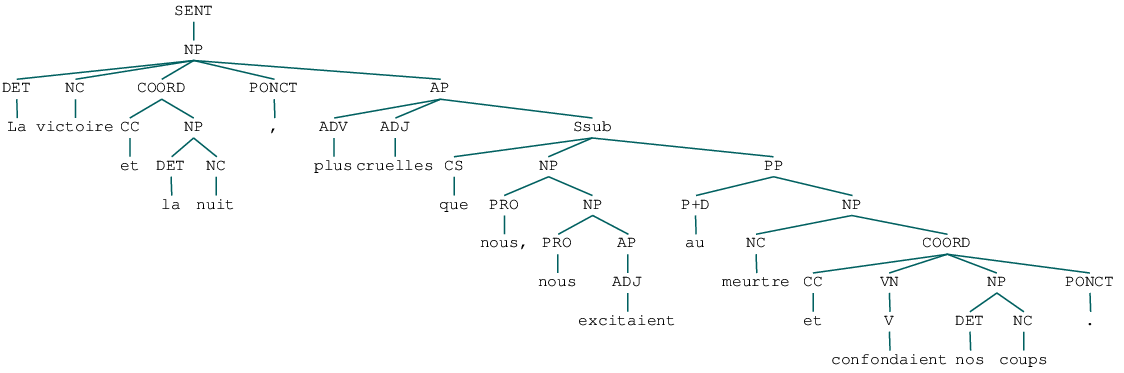

In [42]:
i = 3
print("Original sentence:  %s" % ' '.join(test_sentences[i]))
print("Tokenized sentence: %s" % test_sentences[i])
print("Predicted parse:   %s" % parsed_str[i])
print('---' * 50)
nltk.tree.Tree.fromstring(parsed_str[i])[0]

### Save predictions

In [30]:
output_path = 'test_output.txt'

In [32]:
print("Write predictions in %s..." % output_path, end=' ')
utils.write_in_file(output_path, parsed_str)
print('Done')

Write predictions in test_output.txt... Done


## Get parsing evaluation from labeled data

In [33]:
test_path = 'sequoia-corpus+fct.mrg_strict'
test_start=0.9
test_end = 1

In [34]:
test_sentences, test_labels = data_process.get_to_eval_data(test_path, test_start, test_end)

Loading data...
Generating trees...
Generate validation and test datasets...


In [36]:
parsed_str, score, parsed = utils.evaluate(test_sentences, test_labels, 
                                     train_grammar_rules, train_prob_lexicon, train_rhs_index, train_unary_dic,
                                     oov_handler, p_output=True, 
                                     beam=beam, chrono=True)

1it [00:06,  6.30s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (ADJ 19) (NC janvier) (NC 2004) (PONCT :) (DET le) (NC juge) (ADJ Armand) (ADJ Riberolles) (NC clôt) (DET ses) (NC investigations) (CC et) (DET l') (NC instruction) (P de) (DET l') (NC affaire) (P+D des) (NC HLM) (P de) (NP (NPP Paris)) (PONCT .))


2it [00:14,  6.73s/it]

(SENT (PONCT -) (NP (NC Février) (NC 2005)) (PONCT :) (NP (DET le) (NC parquet) (PP (P de) (NP (NPP Paris)))) (VN (V requiert)) (NP (DET un) (NC non-) (NC lieu)) (PP (P en_faveur_de) (NP (NPP Jean) (NPP Tiberi))) (PONCT ,) (VPpart (VPP accordé) (PP (P par) (NP (DET le) (NC juge))) (NP (ADJ Armand) (NC Riberolles))) (PONCT .))


3it [00:15,  5.08s/it]

(SENT (VN (CLS Il) (V demande)) (ADV toutefois) (NP (DET le) (NC renvoi) (PP (P devant) (NP (DET le) (NC tribunal) (AP (ADJ correctionnel))))) (PP (P de) (NP (DET la) (NC majorité))) (PP (P de) (NP (DET la) (NC cinquantaine))) (PP (P de) (NP (NC personnes) (VPpart (VPP mises) (PP (P en) (NP (NC examen)))))) (PONCT .))


4it [00:56, 15.91s/it]

(SENT (PONCT -) (NP (NC Juin) (NC 2005)) (PONCT :) (NP (DET l') (PREF ex-) (NC conseiller)) (NP (NC général) (NP (NC RPR) (PP (P+D des) (NP (NPP Hauts-de-Seine))) (NPP Didier) (NPP Schuller))) (COORD (CC et) (NP (DET le) (NC député-maire))) (PONCT -LRB-) (NP (NPP UMP) (PONCT -RRB-) (Srel (PP (P de) (NP (NPP Levallois-Perret))) (NP (NPP Patrick) (NPP Balkany)) (VN (V comparaissent)) (PP (P devant) (NP (DET le) (NC tribunal) (AP (ADJ correctionnel)))) (PP (P de) (NP (NPP Créteil))) (PP (P dans) (NP (DET l') (NC affaire))) (NP (DET des) (NC HLM)) (PP (P+D des) (NP (NPP Hauts-de-Seine))))) (PONCT .))
/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NP (NC Procès)) (P en) (ADJ première) (NC instance))


6it [00:57, 11.32s/it]

(SENT (PONCT -) (NP (DET Le) (NC procès) (PP (P de) (NP (DET l') (NC affaire)))) (NP (DET des) (NC HLM) (PP (P de) (NP (NPP Paris)))) (VN (CLR s') (V est) (VPP déroulé)) (PP (P dans) (NP (DET l') (NC indifférence))) (PP (P+D du) (NP (DET 23) (NC décembre) (NC 2005))) (PP (P+D au) (NP (DET 5) (NC avril) (NC 2006))) (PONCT .))


7it [01:03,  9.73s/it]

(SENT (PONCT -) (NP (DET Les) (NC hommes) (AP (ADJ politiques))) (NP (NC -clés) (PP (P de) (DET la)) (AP (ADJ capitale)) (PP (P comme) (NP (NPP Jean) (NPP Tiberi)))) (PONCT ,) (NP (NPP Michel) (NPP Roussin) (COORD (CC ou) (NP (NPP Jacques) (NPP Chirac)))) (VN (V ont) (VPP bénéficié)) (PP (P de) (NP (NC non-) (NC lieu))) (PONCT ,) (NP (DET de) (NC vices)) (PP (P de) (NP (NC forme))) (COORD (CC ou) (PP (P de) (NP (NC protection) (AP (ADJ statutaire))))) (PONCT .))


8it [01:08,  8.19s/it]

(SENT (PP (P Selon) (NP (DET l') (NC accusation) (PONCT :)) (PONCT ")) (NP (DET L') (NC instruction) (ADV n')) (VN (V est)) (NP (NC pas) (VPpart (VPP parvenue) (VPinf (P à) (VN (VINF établir)) (ADV formellement) (NP (DET l') (NC implication) (AP (ADJ personnelle)) (NP (DET des) (NC responsables) (PP (P au_sein_de) (NP (DET l') (NC appareil) (AP (ADJ politique))))) (PP (P+D du) (NP (NPP RPR)))))) (PONCT .)) (PONCT "))


9it [01:19,  9.20s/it]

(SENT (PP (ADV -) (P En) (NP (DET l') (NC absence) (PP (P de) (NP (DET tout) (NC responsable) (AP (ADJ politique)))))) (PONCT ,) (VN (CLS c') (V est)) (NP (DET l') (ADJ ancien) (NC directeur) (AP (ADJ général)) (PP (P de) (NP (DET l') (NPP Office))) (NP (NC public) (NC HLM))) (PP (P de) (NP (NPP Paris))) (COORD (CC et) (NP (NC élu) (AP (ADJ corrézien)))) (PONCT ,) (NP (NPP Georges) (NPP Pérol) (PONCT ,) (Srel (NP (PROREL qui)) (VN (V fait)))) (VN (V figure)) (PP (P de) (NP (NC clé) (PP (P de) (NP (NC voûte))))) (PP (P de) (NP (DET ce) (ADJ vaste) (NC système) (PP (P de) (NP (NC versements) (PP (P de) (NP (NC commissions))) (PP (P par) (NP (DET les) (NC entreprises)))))) (COORD (CC et) (NP (DET de) (NC détournement)))) (PP (P de) (NP (NC procédures) (PP (P dans) (NP (DET l') (NC attribution))) (PP (P de) (NP (NC marchés) (ADJ publics))))) (PONCT .))


10it [01:23,  7.45s/it]

(SENT (PP (P Contre) (NP (PRO lui))) (PONCT ,) (NP (DET le) (NC parquet)) (VN (V a) (VPP requis)) (NP (DET quatre) (NC ans) (PP (P d') (NP (NC emprisonnement)))) (PP (P avec) (NP (NC sursis))) (PONCT ,) (NP (DET 50_000) (NC euros) (PP (P d') (NP (NC amende))) (COORD (CC et) (NP (DET trois) (NC ans) (PP (P d') (NP (NC interdiction) (PP (P+D des) (NP (NC droits) (AP (ADJ civiques))))) (COORD (CC et) (NP (NC civils))))))) (PONCT .))


11it [01:39, 10.15s/it]

(SENT (PONCT -) (NP (DET Le) (ADJ 14) (NC mars) (NC 2006)) (PONCT ,) (NP (DET des) (NC peines) (PP (P de) (NP (NC prison)))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (Sint (NP (DET des) (NC amendes)) (VN (V ont) (VPP été) (VPP requises)) (PP (P contre) (DET 41)) (PP (P+D des) (NP (DET 49) (NC prévenus) (PP (P+D du) (NP (NC procès) (PP (P de) (NP (DET l') (NC office) (AP (ADJ public)))) (NC HLM) (PP (P de) (NP (NPP Paris))))) (PONCT -LRB-) (NP (NC OPAC)) (PONCT -RRB-) (PONCT ,) (VPpart (VPP considérés) (PP (P comme) (NP (DET les) (NC acteurs))) (COORD (CC ou) (NP (DET les) (NC complices) (PP (P d') (NP (DET un) (PONCT ") (NC système))) (PP (P de) (NP (NC fraude) (PP (P de) (NP (ADJ grande) (NC envergure)))))))) (PONCT ,) (VPpart (ADV parfaitement) (VPP organisé) (PONCT ") (COORD (CC et) (VPpart (VPP destiné) (VPinf (P à) (PONCT ") (VN (VINF constituer)) (NP (DET des) (NC caisses) (NC noires)))))) (PONCT "))) (PONCT ,)))) (PP (P selon) (NP (DET les) (NC mots))) (PP (P de) (NP (DET la

12it [01:45,  8.99s/it]

(SENT (NP (NC Évoquant)) (NP (P dès) (DET le) (NC début)) (PP (P de) (NP (DET son) (NC réquisitoire))) (PONCT ,) (PP (P devant) (NP (DET la) (ADJ 11e) (NC chambre) (PP (P+D du) (NP (NC tribunal) (AP (ADJ correctionnel)))) (PP (P de) (NP (NPP Paris))))) (PONCT ,) (NP (DET la) (NC question)) (PP (P+D du) (NP (NC financement) (AP (ADJ politique)))) (PONCT ,) (VN (CLS elle) (V a)) (NP (NC relevé) (ADV que)) (PONCT ") (NP (DET l') (NC instruction)) (VN (ADV n') (V a) (ADV pas) (VPP trouvé)) (PP (P de) (NP (NC réponse))) (COORD (CC et) (VN (CLR s') (V est) (VPP heurtée)) (PP (P+D au) (NP (NC silence) (COORD (CC et) (PP (P+D aux) (NP (NC flux) (AP (ADJ financiers))))))) (PP (P+D des) (NP (NC sociétés) (NC off-shore)))) (PONCT ") (PONCT .))


13it [01:48,  7.20s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (DET 5) (NC avril) (NC 2006) (PONCT :) (AP (ADJ dernier)) (NC jour) (P+D du) (NC procès) (P+D des) (NC HLM) (P de) (NC paris) (VPP consacré) (P+D aux) (NC plaidoiries) (PONCT .))


14it [01:52,  6.14s/it]

(SENT (PP (P Pendant) (NP (DET deux) (NC mois) (COORD (CC et) (NP (NC demi)))) (NP (DET de) (NC débats))) (PONCT ,) (NP (DET une) (NC cinquantaine) (PP (P de) (NP (ADJ chefs) (DET d') (NC entreprise)))) (VN (V ont) (VPP été) (VPP entendus)) (COORD (CC et) (VN (V ont) (VPP reconnu)) (VPinf (VN (VINF avoir) (VPP versé)) (NP (DET des) (NC fonds) (PP (P contre) (NP (DET l') (NC obtention) (PP (P de) (NP (NC marchés) (NP (DET des) (NC HLM))))))) (PP (P de) (NP (NPP Paris))))) (PONCT .))


15it [01:53,  4.65s/it]

(SENT (NP (DET Aucun) (NC financement) (AP (ADJ politique)) (AP (ADJ occulte))) (VN (ADV n') (V a) (VPP pu)) (VPinf (VN (VINF être) (VPP mis)) (PP (P en) (NP (NC évidence)))) (PONCT .))


16it [02:12,  8.74s/it]

(SENT (NP (DET L') (NC utilisation)) (PP (P de) (NP (NC sociétés-écrans) (VPpart (VPP basées) (PP (P dans) (NP (DET des) (NC paradis) (AP (ADJ fiscaux))))))) (PONCT -LRB-) (VPinf (VN (VINF voir)) (NP (NC société) (AP (ADJ panaméenne)) (COORD (CC et) (AP (ADJ fiduciaire))) (AP (ADJ suisse)))) (PONCT -RRB-) (Sint (VN (V a) (VPP empêché)) (VPinf (P de) (VN (VINF retracer)) (NP (DET les) (NC flux) (AP (ADJ financiers))))) (PONCT .))


17it [02:13,  6.57s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Les) (NC marchés) (NP (NC truqués)))


18it [02:15,  5.09s/it]

(SENT (NP (DET Les) (NC ascenseurs) (NP (DET des) (NC HLM))) (PP (P de) (NP (NPP Paris))))


19it [02:24,  6.37s/it]

(SENT (PONCT -) (NP (DET Le) (NC contrat) (PP (P de) (NP (NC maintenance)))) (COORD (CC et) (Sint (NP (DET de) (NC rénovation) (PP (P+D des) (NP (DET 3_092) (NC cabines))) (PP (P d') (NP (NC ascenseurs) (NP (DET des) (NC immeubles) (PP (P d') (NP (NC HLM) (AP (ADJ parisiens)))))))) (VN (V est) (VPP attribué)) (PP (P en) (NP (NC 1992))))) (PONCT .))


20it [02:26,  5.14s/it]

(SENT (NP (DET Le) (NC marché)) (VN (V est)) (AP (ADJ important) (PONCT :) (NP (DET 2,2) (NC milliards) (PP (P de) (NP (NC francs))) (PP (P sur) (NP (DET quinze) (NC ans))) (PONCT ,) (COORD (CC soit) (NP (DET un) (NC budget) (AP (ADJ annuel)) (PP (P de) (NP (DET 140) (NC millions))))) (PP (P de) (NP (NC francs)))) (PONCT .)))


21it [02:37,  6.77s/it]

(SENT (PONCT -) (NP (DET Trois) (NC entreprises)) (VN (V sont)) (NP (NC retenues) (PONCT :) (NP (DET la) (NC Somatem) (NP (PONCT ,) (NC filiale) (VPinf (P de) (VN (CLO la) (V Lyonnaise)) (NP (DET des) (NC eaux)) (PONCT ,) (NP (DET la) (NPP CG2A)) (PONCT ,) (NP (NC filiale) (PP (P de) (NP (DET l') (PREF ex-) (NC Compagnie))) (AP (ADJ générale)) (VPpart (NP (DET des) (NC eaux) (PONCT -LRB-) (NP (NC CGE)) (PONCT ,)) (VPP devenue))))) (NPP Vivendi)) (PONCT -RRB-)) (PONCT ,) (COORD (CC et) (NP (DET le) (NC groupe) (AP (ADJ américain)) (NPP Otis))) (PONCT .))


22it [02:43,  6.41s/it]

/!\ PARTIAL PARSING /!\	(SENT (CC Otis) (VN (V refuse)) (P de) (VN (VINF traiter)) (P avec) (NPP Jean-Claude) (NC Méry) (CC et) (VN (VINF obtiendra)) (DET un) (ADJ petit) (NC lot) (P en) (VPP rémunérant) (DET un) (ADJ autre) (NC intermédiaire) (PONCT .))


23it [02:48,  6.06s/it]

(SENT (PONCT -) (NP (DET L') (NC enquête)) (VN (V a) (VPP montré)) (ADV que) (PONCT ,) (PP (P pour) (NP (DET cet) (NC appel))) (PP (P d') (NP (NC offres))) (PONCT ,) (NP (DET des) (NC commissions)) (VN (V avaient) (VPP été) (VPP versées)) (PP (PONCT ,) (P via) (NP (DET le) (NC règlement) (PP (P de) (NP (NC factures))))) (PP (P d') (NP (PONCT ") (NC assistance) (AP (ADJ commerciale)) (PONCT ") (PP (P à) (NP (NP (DET l') (PRO une)) (DET des) (NC sociétés)))) (PP (P de) (NP (NPP Jean-Claude) (NPP Méry)))) (PONCT .))


24it [02:56,  6.63s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Un) (NP (NC dirigeant)) (P de) (DET la) (NPP CG2A) (PONCT ,) (P lors_de) (DET l') (NC attribution) (P+D du) (NC marché) (PONCT ,) (V a) (ADV ainsi) (VPP déclaré) (P+D au) (NC juge) (VINF avoir) (VPP acquitté) (P de) (NC semblables) (NC factures) (P+D au) (NC mois) (P de) (NC février) (NP (NC 1992)) (PONCT ") (CS parce_que) (DET la) (NC commission) (P d') (NC appel) (P d') (NP (NC offres)) (CLR se) (V réunissait) (DET la) (NC semaine) (AP (ADJ suivante)) (PONCT ") (PONCT .))


25it [02:58,  5.35s/it]

(SENT (NP (NPP Jean-Claude) (NPP Méry)) (PONCT ,) (VN (V expliquait) (CLS -il)) (PONCT ,) (Sint (NP (PRO lui)) (VN (V avait) (VPP mis))) (PONCT ") (NP (DET le) (NC couteau) (PP (P sous) (NP (DET la) (NC gorge)))) (PONCT ") (PONCT .))


26it [03:12,  7.95s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NP (NC dirigeant)) (P de) (DET la) (NC Somatem) (PONCT ,) (CLO lui) (PONCT ,) (V avait) (VPP confirmé) (PONCT ,) (P sur) (VN (V procès-verbal)) (PONCT ,) (CS que) (DET ce) (NC marché) (VN (V devait)) (VN (VINF entraîner)) (PONCT ") (DET le) (NC versement) (P d') (DET une) (NC commission) (P d') (P entre) (DET 1) (NC %) (CC et) (DET 5) (NC %) (P+D du) (NC montant) (P+D du) (NC marché) (PONCT ,) (PP (PROREL dont)) (DET le) (NC paiement) (VN (V devait)) (CLR s') (VN (VINF effectuer)) (AP (ADJ à_l'_étranger)) (PONCT ") (PONCT .))


27it [03:15,  6.32s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (VPP Questionné) (DET le) (ADJ 11) (NC mai) (NP (NC 1998)) (PONCT ,) (NPP Jean-Claude) (NC Méry) (V avait) (PONCT ,) (P pour) (DET sa) (NP (NC part)) (PONCT ,) (VPP reconnu) (VINF avoir) (PONCT ") (VPP demandé) (DET 1,5) (NC %) (P+D du) (NC marché) (PONCT ,) (NP (PROREL qui)) (PONCT [) (CLO lui) (PONCT ]) (V ont) (VPP été) (VPP versés) (P en) (NP (NPP Suisse)) (PONCT ") (PONCT ,) (CC mais) (CLS il) (ADV n') (V avait) (ADV pas) (VPP évoqué) (P de) (NC destination) (AP (ADJ politique)) (PONCT .))


28it [03:18,  5.30s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Collusions) (AP (ADJ maçonniques)))


29it [03:27,  6.57s/it]

/!\ PARTIAL PARSING /!\	(SENT (P Comme) (P dans) (DET d'_autres) (NC affaires) (PREF politico-) (AP (ADJ financières)) (AP (ADJ françaises)) (P+D des) (NC années) (NC 1990) (PONCT ,) (DET plusieurs) (NC protagonistes) (P de) (DET cette) (NC affaire) (V appartiennent) (P à) (P+D des) (NC loges) (AP (ADJ maçonniques)) (PONCT :) (NPP Jean-Claude) (NC Méry) (PONCT ,) (NPP Jacky) (NPP Chaisaz) (PONCT ,) (NPP Didier) (VN (VINF Schuller)) (PONCT -LRB-) (NC loge) (NC Silence) (P de) (DET la) (NPP GLNF) (PONCT -RRB-) (PONCT .))
(SENT (NP (NC Références)))


31it [03:35,  5.84s/it]

(SENT (NP (ADV -) (NC HLM)) (PP (P de) (NP (NPP Paris) (PONCT :) (NP (DET les) (ADJ seuls) (NC patrons) (NP (DET du) (NC bâtiment)))) (PP (P à) (NP (DET la) (NC barre) (COORD (PONCT -) (NP (NPP Libération))) (COORD (PONCT -) (DET 23/12/2006))))))
/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (DET Le) (NPP Monde) (P+D du) (DET 22) (NC septembre) (NC 2000))
(SENT (NP (NC Catégories)) (PONCT :) (NP (NC Affaire) (AP (PREF politico-) (ADJ financière) (AP (ADJ française)))) (PONCT .))
(SENT (NP (NC Financement) (AP (ADJ illégal))) (PP (P+D des) (NP (NC partis) (PONCT .))))


35it [03:37,  4.19s/it]

(SENT (VPpart (VPP Rassemblement) (NP (P pour) (DET la) (NC République))) (PONCT .))
(SENT (NP (NPP Paris)) (PONCT .))
(SENT (NP (NC Histoire)) (PP (P de) (NP (NPP Paris))))


38it [03:46,  3.86s/it]

(SENT (NP (NC Affaire) (PP (P+D des) (NP (NC marchés) (ADJ publics)))) (PP (P d') (NC Île-de-France)))


39it [04:08,  9.45s/it]

(SENT (NP (DET L') (NC affaire) (NP (DET des) (NC marchés) (AP (ADJ publics) (PP (P d') (NP (NPP Île-de-France))) (COORD (CC ou) (NP (NC Affaire) (PP (P+D des) (NP (NC marchés) (AP (ADJ truqués))))) (NP (DET des) (NC lycées))))) (PP (P d') (NP (NPP Île-de-France)))) (VN (V est)) (NP (DET un) (NC dossier) (AP (ADJ emblématique))) (NP (DET des) (NC dérives) (PP (P+D du) (NP (NC financement))) (NP (DET des) (NC partis) (AP (ADJ politiques)) (PP (P dans) (NP (DET les) (NC années) (NC 1990))))) (PONCT .))


40it [04:13,  7.94s/it]

(SENT (NP (DET Cette) (NC affaire) (AP (PREF politico-) (ADJ financière) (AP (ADJ française)))) (VN (V porte)) (PP (P sur) (NP (DET le) (NC financement))) (PP (P par) (NP (DET les) (NC marchés))) (PP (P de) (NP (NC construction) (COORD (CC et) (PP (P d') (NP (NC entretien) (NP (DET des) (NC lycées)))) (NP (DET des) (ADJ grands) (NC partis) (AP (ADJ politiques)) (AP (ADJ français)) (PONCT :) (NP (NPP RPR) (PONCT ,) (NPP PR) (PONCT ,) (NP (NPP PS)) (PONCT ,)))) (NC PCF) (PONCT ,) (VPpart (VPP organisés) (PP (P en) (NC cartel))))) (PONCT .))


41it [04:16,  6.54s/it]

(SENT (NP (ADJ Seuls) (DET les) (NC Verts) (COORD (CC et) (DET le)) (PP (NP (NC FN) (VPinf (ADV n') (VN (V ont) (ADV pas) (VPP participé)))) (P à))) (NP (DET ce) (NC détournement)) (PONCT .))


42it [04:24,  6.87s/it]

(SENT (NP (DET Les) (NC montants) (NC détournés) (Srel (PP (P+D aux) (NP (NC frais))) (NP (DET du) (NC contribuable) (AP (ADJ francilien))) (VN (CLR se) (V montent)) (PP (P à) (NP (DET plusieurs) (NC dizaines))) (PP (P de) (NP (NC millions) (PP (P d') (NP (NC euros))))))) (PONCT -LRB-) (NP (DET 300) (P à) (DET 600) (NC millions)) (PP (P de) (NP (NC francs))) (PONCT -RRB-) (PONCT .))


43it [04:35,  8.05s/it]

(SENT (NP (DET La) (NC rénovation) (NP (DET des) (NC lycées))) (PP (P d') (NC Île-de-France)))


44it [04:52, 10.89s/it]

(SENT (NP (NC Chargé) (NP (DET des) (NC lycées))) (PP (P depuis) (NP (DET les) (ADJ premières) (NC lois) (PP (P de) (NP (NC décentralisation) (PONCT ,) (NP (DET le) (NC conseil) (AP (ADJ régional))))) (VPpart (VPP dirigé) (PP (P par) (NP (DET le) (NC RPR)) (COORD (CC et) (Srel (PP (PROREL dont)) (NP (DET le) (NC président)) (VN (V était)) (NP (NPP Michel) (NPP Giraud)))))))) (VN (V a) (VPP engagé)) (PONCT ,) (PP (P entre) (NP (NC 1988)) (COORD (CC et) (NP (NC 1997)))) (PONCT ,) (NP (DET 24) (NC milliards) (PP (P de) (NP (NC francs) (PP (P de) (NP (NC travaux))) (PP (P de) (NP (NC rénovation)))))) (PONCT ,) (NP (NC extension) (COORD (CC et) (Sint (NP (NC construction) (PP (P dans) (NP (DET 471) (NC établissements)))) (PONCT ,) (VN (CLS il) (V a) (VPP été)) (NP (ADJ prélevé) (DET 2) (NC %) (PP (P de) (NP (PONCT ") (NC commissions) (AP (ADJ occultes)) (PONCT ") (Ssub (CS que) (VN (CLR se) (V sont) (VPP partagés)) (NP (DET ces) (ADJ grands) (NC partis))))) (PONCT ,) (PP (P+D au) (NP (NC pr

45it [05:09, 12.63s/it]

(SENT (PP (P Selon) (NP (DET l') (NC accusation))) (NP (PONCT ,) (DET les) (NC entreprises) (Srel (NP (PROREL qui)) (VN (CLR se) (V voyaient) (VPP attribuer)) (NP (DET des) (NC marchés) (PP (P de) (NP (NC construction) (NP (DET des) (NC lycées) (PP (P d') (NP (NPP Île-de-France))))))))) (VN (V devaient)) (VPinf (VN (VINF reverser)) (NP (DET 2) (NC %) (PP (P de) (NP (DET leurs) (NC montants))))) (PP (P+D aux) (NP (NC partis) (PONCT :) (NC RPR))) (PONCT ,) (NP (NPP PS)) (PONCT ,) (NP (NC Parti) (AP (ADJ républicain))) (PONCT .))


46it [05:12,  9.88s/it]

(SENT (NP (AP (DET La) (AP (ADV plus) (ADJ grosse))) (NC part)) (PONCT -LRB-) (NP (DET 1,2) (NC %)) (PONCT -RRB-) (NP (DET du) (PONCT ") (NPP racket) (PONCT ")) (VN (V revint)) (PP (P+D au) (NP (NPP RPR))) (PONCT ,) (VPpart (ADV alors) (VPP dirigé) (PP (P par) (NP (NPP Jacques) (NPP Chirac)))) (PONCT ,) (VPpart (VPP secondé) (PP (P par) (NP (NPP Michel) (NPP Roussin)))) (PONCT .))


47it [05:19,  8.82s/it]

(SENT (NP (P En) (DET cinq) (NC ans)) (PONCT ,) (PP (P pour) (NP (DET la) (ADJ seule) (NC période) (VPpart (VPP comprise) (PP (P entre) (NP (NC 1990) (COORD (CC et) (NP (NC 1995)))))))) (PONCT ,) (NP (DET le) (NC RPR)) (VN (V recevra)) (NP (DET 53) (NC millions) (PP (P de) (NP (NC francs))) (PONCT ,) (Sint (NP (DET le) (NPP PS)) (VN (V arrive)) (PP (P en) (NP (ADJ deuxième) (NC position)))) (PONCT ,) (PP (P avec) (NP (DET 46,7) (NC millions))) (PONCT ,) (VPpart (VPP suivi) (PP (P+D du) (NP (NC Parti) (AP (ADJ républicain)))) (PONCT -LRB-) (NP (DET 32,6) (NC millions))) (PONCT -RRB-) (COORD (CC et) (NP (DET du) (NC PCF))) (PONCT -LRB-) (NP (DET 21) (NC millions)) (PONCT -RRB-)) (PONCT .))


48it [05:27,  8.82s/it]

(SENT (ADV Soit) (Sint (PONCT ,) (ADV au_total) (PONCT ,) (NP (ADV un_peu_plus) (P de) (DET 150) (NC millions) (PP (P de) (NP (NC francs)))) (VN (V ont) (VPP été) (VPP versés)) (PP (P par) (NP (DET les) (ADJ grands) (NC groupes))) (COORD (PONCT :) (AP (ADJ Bouygues)))) (PONCT ,) (NP (NPP Eiffage) (PONCT ,) (NPP Spie-Batignolles) (PONCT ,) (NP (NPP Suez) (COORD (CC et) (AP (ADJ Générale))))) (NP (DET des) (NC eaux)) (PONCT .))


49it [05:29,  6.52s/it]

(SENT (NC Protagonistes))
/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Michel) (NPP Roussin) (PONCT ,) (PREF ex-) (NC bras) (NC droit) (P de) (NPP Jacques) (NPP Chirac) (P à) (DET la) (NC mairie) (P de) (NP (NPP Paris)) (PONCT .))


51it [05:42,  6.60s/it]

(SENT (PONCT -) (NP (NPP Louise-Yvonne) (NPP Casetta)) (NP (PONCT ,) (NC trésorière) (AP (ADJ occulte)) (PP (P+D du) (NP (NPP RPR)))) (PONCT ,) (NP (NC ancêtre) (PP (P de) (NP (DET l') (NPP UMP)))) (PONCT .))


52it [05:47,  5.97s/it]

(SENT (PONCT -) (NP (NPP Jean-Claude) (NPP Méry)) (NP (PONCT ,) (ADJ ancien) (NC collecteur) (PP (P de) (NP (NC fonds) (VPpart (NP (NC occulte) (PP (P+D du) (NP (NPP RPR))) (PONCT ,)) (VPP décédé))))) (PONCT .))


53it [05:53,  5.96s/it]

(SENT (NP (DET Le) (NC dossier) (PP (P d') (NP (NC instruction)))) (VN (V comporte)) (NP (DET ses) (NC célèbres)) (PONCT ") (NP (NC confessions) (PONCT ") (NC posthumes) (PONCT ,) (VPpart (VPP publiées) (PP (P en) (NP (NC 2000)))) (PONCT -LRB-) (NP (NPP Cassette) (NPP Méry)) (PONCT -RRB-)) (PONCT .))


54it [05:57,  5.66s/it]

(SENT (VPinf (VN (CLS Il) (CLO y) (V racontait)) (ADV notamment) (VPinf (VN (VINF avoir) (VPP remis)) (NP (ADV peronnellement) (DET des) (NC fonds) (PP (P en) (NP (NC espèces))) (PP (P en) (NP (NC 1986)))) (PP (P à) (NP (NPP Jacques) (NPP Chirac))) (PP (P en_présence_de) (NP (NPP Michel) (NPP Roussin))))) (PONCT .))


55it [06:04,  5.79s/it]

(SENT (NP (PONCT -) (NPP Gérard) (NC Peybernès) (PONCT ,)) (NP (PREF ex-) (NC président) (PP (P de) (NP (DET l') (NC association))) (PP (P de) (NP (NC financement))) (PP (P+D du) (NP (NPP PS)))) (PONCT .))


56it [06:23,  9.95s/it]

(SENT (PONCT -) (NP (NPP Jean-Pierre) (NPP Thomas)) (PONCT ,) (NP (ADJ ancien) (NC trésorier) (PP (P+D du) (NP (NC Parti) (AP (ADJ républicain)))) (NPP Jean-Pierre) (NPP Thomas) (PONCT -LRB-) (NP (DET 15) (NC mois) (PP (P avec) (NP (NC sursis))))) (COORD (CC et) (NP (DET 5.000) (NC euros) (PP (P d') (NP (NC amende))))) (PONCT -RRB-) (PONCT .))


57it [06:24,  7.28s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Guy) (AP (ADJ Drut)))


58it [06:25,  5.45s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Gérard) (ADJ Longuet))


59it [06:27,  4.15s/it]

(SENT (NP (DET Les) (NC voyages)) (PP (P de) (NP (NPP Jacques) (NPP Chirac))))


60it [06:31,  4.22s/it]

(SENT (NP (NP (DET L') (PRO un)) (DET des) (NC volets) (PP (P de) (Sint (NP (DET ce) (NC dossier)) (VN (V concerne)) (NP (DET les) (NC voyages))))) (NP (NC payés) (PP (P en) (NP (NC espèces))) (PP (P par) (NP (NPP Jacques) (NPP Chirac) (PONCT -LRB-) (NP (NC Affaire) (NP (DET des) (NC billets) (PP (P d') (NP (NC avion)))) (PP (P de) (NP (NPP Jacques) (NPP Chirac)))) (PONCT -RRB-)))) (PONCT .))


61it [06:47,  7.82s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET La) (NC justice) (V soupçonne) (CS que) (DET l') (NC argent) (AP (ADJ liquide)) (VPR ayant) (VPP servi) (P à) (VN (VINF régler)) (DET les) (NC billets) (P d') (NC avion) (PONCT -LRB-) (P pour) (DET un) (NC montant) (P de) (DET 336.210,00) (P EUR) (PONCT -RRB-) (VN (VS puisse)) (VN (VINF provenir)) (P de) (NC versements) (P en) (NC espèces) (P+D des) (NC commissions) (V occultes) (VPP versées) (P par) (DET les) (NP (NC entreprises)) (P de) (NP (NC BTP)) (AP (ADJ attributaires)) (P+D des) (NC marchés) (ADJ publics) (PONCT ,) (DET ce) (NP (PROREL qui)) (V serait) (DET un) (NC abus) (P de) (NC biens) (AP (ADJ sociaux)) (PONCT .))


62it [06:52,  7.00s/it]

(SENT (NP (NPP Jacques) (NPP Chirac)) (VN (V affirme)) (ADV que) (NP (DET cette) (NC somme) (PONCT ,) (Srel (NP (PROREL qui)) (VN (ADV n') (V apparaît)) (ADV pas))) (PP (P dans) (NP (DET sa) (NC déclaration))) (PP (P de) (NP (NC patrimoine))) (PONCT ,) (VN (V provient)) (NP (DET des) (NC fonds) (AP (ADJ spéciaux)) (VPpart (VPP conservés) (Ssub (CS lorsqu') (VN (CLS il) (V était)) (NP (ADJ Premier) (NC ministre))))) (PONCT .))


63it [07:03,  8.23s/it]

(SENT (NP (DET Aucun) (NC lien)) (ADV n') (VPinf (VN (V a) (VPP pu)) (VPinf (VN (VINF être) (VPP établi)) (PP (P entre) (NP (DET ces) (NC espèces)))) (COORD (CC et) (NP (DET l') (NC argent) (PP (P de) (NP (DET la) (NC corruption)))) (NP (DET des) (NC marchés) (PP (P d') (NP (NPP Île-de-France))) (PONCT .)))))


64it [07:18, 10.26s/it]

(SENT (PP (P Selon) (DET le)) (NP (NC procureur) (NPP Jean-Pierre) (NPP Dintilhac) (PONCT ,) (NP (PRO rien) (ADV ne))) (VN (CLR s') (V opposait)) (PP (P à) (NP (DET une) (NC audition))) (PP (P de) (NP (NPP Jacques) (NPP Chirac))) (PP (P comme) (NP (NC témoin) (VPpart (VPP assisté) (PP (P dans) (NP (DET cette) (NC affaire)))))) (PONCT .))


65it [07:23,  8.63s/it]

/!\ PARTIAL PARSING /!\	(SENT (ADV Cependant) (PONCT ,) (P par) (DET un) (NC jugement) (P de) (DET la) (NC Cour) (P de) (NP (NC cassation)) (PONCT ,) (DET les) (NC tribunaux) (ADV ne) (VN (V peuvent)) (VN (VINF examiner)) (DET les) (NC investigations) (VPP menées) (P sur) (DET les) (NC voyages) (VPP payés) (P en) (NC espèces) (P par) (NPP Jacques) (NPP Chirac) (P pour) (DET plusieurs) (NC millions) (P de) (NP (NC francs)) (PONCT ,) (NP (PROREL qui)) (V avaient) (VPP motivé) (P en) (NP (NC 2001)) (DET l') (NC interrogatoire) (P par) (DET les) (NC juges) (P d') (NC instruction) (P de) (DET plusieurs) (ADJ proches) (P+D du) (NC chef) (P de) (DET l') (NC État) (PONCT ,) (PP (PROREL dont)) (DET sa) (NC fille) (NPP Claude) (NPP Chirac) (PONCT .))


66it [07:30,  8.15s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NC chef) (P de) (DET l') (NC État) (PONCT ,) (NP (PROREL qui)) (VN (VINF bénéficie)) (P d') (DET une) (NC immunité) (AP (ADJ pénale)) (P pendant) (DET la) (NC durée) (P de) (DET son) (NC mandat) (PONCT ,) (ADV n') (V a) (ADV jamais) (VPpart (VPP commenté)) (P en) (NC détail) (DET le) (NC dossier) (PONCT ,) (VN (VPR expliquant)) (ADV simplement) (P en) (NC 2000) (CS qu') (CLS il) (ADV ne) (PONCT ") (V pouvait) (ADV pas) (VINF croire) (PONCT ") (P à) (DET une) (NC corruption) (VN (VPR impliquant)) (NC droite) (CC et) (AP (ADJ gauche)) (PONCT .))


67it [07:31,  6.04s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Enquête) (CC et) (NC instruction))


68it [07:36,  5.56s/it]

(SENT (NP (DET L') (NC affaire)) (VN (V fut) (VPP instruite)) (PP (P par) (NP (DET le) (NC juge))) (NP (ADJ Armand) (NC Riberolles)) (PP (P à_partir_de) (NP (NC 1997))) (PONCT .))


69it [07:49,  7.87s/it]

(SENT (NP (DET Le) (ADJ 1er) (NC décembre) (NC 2000) (PONCT ,) (NP (NPP Michel) (NPP Roussin) (PONCT ,) (NP (ADJ ancien) (NC ministre) (NC RPR))) (COORD (CC et) (NP (ADJ ancien) (NC directeur) (PP (P+D du) (NP (NC cabinet))) (NP (DET de) (NPP Jacques))))) (NP (NPP Chirac) (PP (P à) (NP (DET la) (NC Mairie))) (PP (P de) (NP (NPP Paris)))) (PONCT ,) (NP (Sint (VN (V est) (VPP incarcéré)) (PONCT ,) (Ssub (CS tandis_que) (NP (NPP Louise-Yvonne) (NPP Casetta))) (PONCT ,) (NP (PREF ex-) (NC trésorière))) (NC officieuse)) (PP (P+D du) (NP (NPP RPR))) (PONCT ,) (VN (V est) (VPP mise)) (PP (P en) (NP (NC examen))) (PONCT .))


70it [07:51,  6.17s/it]

(SENT (NP (NPP Michel) (NPP Roussin)) (VPinf (VN (V est) (VPP libéré)) (PP (P sous) (NP (NC caution))) (COORD (CC et) (NP (NC placé) (PP (P en) (NP (NC liberté))) (PP (P sous) (NP (NC contrôle) (AP (ADJ judiciaire)) (NP (DET le) (ADJ 5) (NC décembre) (NC 2000)))) (PONCT .)))))


71it [07:57,  5.96s/it]

(SENT (NP (DET Le) (NC juge) (ADJ Armand) (NC Riberolles)) (VPinf (VN (V a) (VPP renvoyé)) (NP (NPP Michel) (NPP Roussin)) (COORD (CC et) (NP (ADJ 46) (NC personnes) (PP (P devant) (NP (DET le) (NC tribunal) (AP (ADJ correctionnel)))) (PONCT .)))))


72it [08:01,  5.50s/it]

(SENT (NP (DET Le) (ADJ 11)) (NP (NC février) (NC 2004)) (PONCT ,) (NP (DET l') (NC ordonnance) (PP (P de) (NP (NC renvoi) (PP (P devant) (NP (DET le) (NC tribunal) (Srel (PP (P de) (NP (DET 47) (NC prévenus))) (VN (V a) (VPP été) (VPP signé)) (PP (P par) (NP (DET le) (NC juge))) (NP (ADJ Armand) (NC Riberolles)))))))) (PONCT .))


73it [08:02,  4.20s/it]

(SENT (PP (P Dans) (DET son)) (NP (NC ordonnance) (COORD (PONCT ,) (Sint (NP (NPP Jacques) (NPP Chirac)) (VN (V est) (VPP évoqué)) (NP (ET a) (NP (DET plusieurs) (NC reprises))))) (PONCT ,) (COORD (CC mais) (Sint (NP (DET le) (NC juge)) (VN (ADV ne) (V peut))))) (VN (ADV pas) (VINF poursuivre)) (NP (DET le) (NC président) (PP (P de) (NP (DET la) (NPP république)))) (Srel (NP (PROREL qui)) (VN (V est) (VPP protégé)) (PP (P par) (NP (DET son) (NC immunité)))) (PONCT .))


74it [08:04,  3.31s/it]

(SENT (NP (NC Procès)) (PP (P en) (AP (ADJ correctionnelle))))


75it [08:06,  3.16s/it]

(SENT (NP (DET Une) (AP (ADJ cinquantaine) (Ssub (NP (P de) (NC personnes)) (VN (V ont) (VPP été) (VPP renvoyée))))) (PP (P devant) (NP (DET le) (NC tribunal) (AP (ADJ correctionnel)) (PP (P de) (NP (NPP Paris))) (PONCT .))))


76it [08:07,  2.53s/it]

(SENT (NP (DET Le) (NC procès)) (PP (P en) (NP (ADJ première) (NC instance))) (VN (CLR s') (V est) (VPP terminé)) (NP (DET le) (NC mercredi)) (NP (ADJ 26) (NC octobre) (NC 2005)) (PONCT .))
/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NC tribunal) (V a) (VPP condamné) (DET 43) (NC prévenus) (PONCT ,) (PP (PROREL dont)) (DET 14) (V ont) (VPP fait) (NC appel) (PONCT .))


78it [08:09,  1.94s/it]

(SENT (PONCT -) (NP (NPP Michel) (NPP Giraud)) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 4) (NC ans))) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (NP (DET 80_000) (NC euros) (PP (P d') (NP (NC amende)))))) (PONCT .))


79it [08:10,  1.67s/it]

(SENT (VPinf (P À) (VN (VINF noter)) (Ssub (CS que) (NP (DET le) (NC parquet)) (VN (V avait) (VPP demandé)) (NP (DET un) (NC an) (PP (P de) (NP (NC prison) (AP (ADJ ferme))))) (PP (P contre) (NP (PRO lui))))) (PONCT .))


80it [08:15,  2.87s/it]

(SENT (NP (DET Cette) (NC peine) (VPpart (VPP inclut) (NP (DET une) (NC privation) (PP (P+D des) (NP (NC drois) (AP (ADJ civiques)))) (COORD (PONCT ,) (NP (NC civils))) (COORD (CC et) (PP (P de) (NP (NC famille)))) (PP (P pendant) (DET une))))) (NP (NC durée) (PP (P de) (NP (DET cinq) (NC ans)))) (PONCT .))


81it [08:18,  2.81s/it]

(SENT (PONCT -) (NP (NPP Michel) (NPP Roussin) (PONCT ,) (VPpart (VPP reconnu) (NP (ADJ coupable) (DET de) (NC complicité) (COORD (CC et) (NP (NC recel) (PP (P de) (NP (NC corruption) (COORD (PONCT ,) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 4) (NC ans) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis)))))) (COORD (CC et) (NP (DET une) (NC amende))))))) (PP (P de) (NP (DET 50_000) (NC euros)))))) (PONCT .))


82it [08:25,  4.00s/it]

(SENT (PONCT -) (NP (NPP Guy) (AP (ADJ Drut))) (PONCT ,) (NP (NC député) (NPP UMP)) (PONCT ,) (NP (NC champion) (AP (ADJ olympique)) (PP (P+D du) (NP (DET 110) (NC mètres))) (NP (NC haies) (PP (P en) (NP (NC 1976)) (COORD (CC et) (NP (NC ministre) (PP (P+D des) (NP (NC Sports)))))) (NC RPR) (PP (P de) (NP (NC 1995))) (PP (P à) (NP (NC 1997))))) (PONCT ,) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 15) (NC mois) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis))))) (COORD (CC et) (NP (DET 50.000) (NC euros) (PP (P d') (NP (NC amende)))) (PP (P pour) (NP (DET un) (NC emploi) (AP (ADJ fictif))))) (PONCT .))


83it [08:27,  3.53s/it]

(SENT (NP (NPP Guy) (AP (ADJ Drut))) (VN (V a)) (NP (NC été)) (NP (NC amnistié) (PP (P en) (NP (NC mai) (NP (NC 2006) (PP (P par) (NP (DET le) (NC président))) (NPP Jacques) (NPP Chirac))))) (PONCT .))


84it [08:34,  4.56s/it]

(SENT (NP (DET Son) (NC casier) (AP (ADJ judiciaire)) (VPpart (ADV ainsi) (VPP blanchi))) (PONCT ,) (NP (NPP Guy) (AP (ADJ Drut))) (VN (V a) (VPP pu) (VINF garder)) (NP (DET son) (NC siège)) (PP (P de) (NP (NC membre) (PP (P+D du) (NP (NC Comité) (AP (ADJ international)) (AP (ADJ olympique)) (PONCT -LRB-) (NP (NC CIO)) (PONCT -RRB-))))) (COORD (CC et) (NP (DET les) (NC avantages))) (COORD (CC et) (NP (NC prébendes) (PP (P de) (NP (DET cette) (NC fonction))))) (PONCT .))


85it [08:41,  5.38s/it]

(SENT (PONCT -) (NP (NPP Jean-François) (NPP Donzel) (PONCT ,) (NP (NC élu) (AP (ADJ écologiste)))) (VN (V dissident)) (PP (P de) (NP (NC Génération) (AP (ADJ écologie)))) (PONCT ,) (Sint (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET un) (NC an))) (PP (P de) (NP (NC prison) (AP (ADJ ferme)))) (PONCT -LRB-) (NP (DET trois) (NC ans) (PP (P de) (NP (NC prison))) (Srel (PP (PROREL dont)) (NP (PRO deux) (PP (P avec) (NP (NC sursis))))))) (PONCT -RRB-) (PONCT .))


86it [08:45,  4.79s/it]

(SENT (PONCT -) (NP (NPP Gérard) (NPP Longuet) (PONCT ,) (NP (DET l') (ADJ ancien) (NC président))) (NP (DET du) (NC Parti) (AP (ADJ républicain))) (PONCT ,) (VN (V a) (VPP été)) (VPpart (VPP relaxé)) (PONCT .))


87it [09:01,  8.27s/it]

(SENT (PONCT -) (NP (NPP Louise-Yvonne) (NPP Casetta) (PONCT ,) (NP (NC trésorière) (AP (ADJ occulte)))) (NP (DET du) (NC RPR) (COORD (PONCT ,) (Sint (VN (V a) (VPP été) (VPP reconnue)) (AP (ADJ coupable) (PP (P de) (NP (NC complicité)))) (COORD (CC et) (NP (NC recel) (NP (DET de) (NC corruption)))))) (PONCT ,) (COORD (CC et) (Sint (VN (V a) (VPP été) (VPP condamnée)) (PP (P à) (NP (DET 20) (NC mois))) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (NP (DET 10_000) (NC euros) (PP (P d') (NP (NC amende)))))) (PONCT .)))))


88it [09:10,  8.53s/it]

(SENT (PONCT -) (NP (NPP Gérard) (NPP Peybernès)) (PONCT ,) (NP (PREF ex-) (NC président) (PP (P de) (NP (DET l') (NC association))) (PP (P de) (NP (NC financement))) (PP (P+D du) (NP (NPP PS)))) (PONCT ,) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 15) (NC mois))) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (NP (DET 8.000) (NC euros) (PP (P d') (NP (NC amende)))))) (PONCT .))


89it [09:22,  9.43s/it]

(SENT (PONCT -) (NP (NPP Jean-Pierre) (NPP Thomas)) (PONCT ,) (NP (ADJ ancien) (NC trésorier)) (PP (P+D du) (NP (NC Parti) (AP (ADJ républicain)))) (PONCT ,) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 15) (NC mois))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (NP (DET 5.000) (NC euros) (PP (P d') (NP (NC amende)))))) (PONCT .))


90it [09:23,  6.92s/it]

(SENT (PONCT -) (NP (DET Des) (ADJ chefs)) (NP (DET d') (NC entreprise)) (VN (V ont) (ADV également) (VPP été) (VPP condamnés)) (PONCT .))
(SENT (NP (NC Procès)) (PP (P en) (NC appel)))


92it [09:31,  6.10s/it]

(SENT (NP (DET Onze) (NC personnes)) (VN (V comparaissent)) (PP (P dans) (NP (DET un) (NC procès))) (PP (P en) (NP (NC appel))) (PP (P à_partir_du) (NP (DET 17) (NC octobre) (NC 2006))) (PONCT .))


93it [09:50,  9.75s/it]

/!\ PARTIAL PARSING /!\	(SENT (P En) (ADJ grande) (NC majorité) (PONCT ,) (DET les) (VPP condamnés) (V ont) (VPP renoncé) (P à) (VINF faire) (NC appel) (PONCT ,) (P comme) (DET l') (PREF ex-) (NC président) (P+D du) (NC conseil) (AP (ADJ régional)) (NPP Michel) (NPP Giraud) (PONCT ,) (DET l') (PREF ex-) (NC trésorier) (P+D du) (VPP Parti) (AP (ADJ républicain)) (NP (NPP Jean-Pierre)) (NPP Thomas) (CC et) (NPP Gérard) (NPP Peybernès) (PONCT ,) (ADJ ancien) (NC président) (P de) (DET l') (NC association) (AP (ADJ nationale)) (P de) (NC financement) (P+D du) (NPP PS) (PONCT .))


94it [09:51,  7.18s/it]

(SENT (NP (DET Le) (NC procès)) (VN (V doit)) (VPinf (VN (CLR s') (VINF étaler))) (PP (P sur) (NP (DET cinq) (NC semaines))) (PONCT ,) (PP (P+D jusqu'_au) (NP (DET 22) (NC novembre) (NC 2006))) (PONCT ,) (PP (P à_raison_de) (NP (DET deux) (NC jours))) (PP (P d') (NP (NC audience) (PP (P par) (NP (NC semaine) (ADV en_moyenne))))) (PONCT .))


95it [09:52,  5.36s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET L') (NC audience) (P d') (NC appel) (VN (V survient)) (P après) (DET la) (NC nomination) (P par) (NPP Jacques) (NPP Chirac) (DET le) (ADJ 13) (NC septembre) (NC 2006) (P d') (DET un) (P de) (DET ses) (ADJ anciens) (NP (NC conseillers)) (PONCT ,) (NPP Laurent) (DET Le) (NC Mesle) (PONCT ,) (P+D au) (NC poste) (P de) (NC procureur) (NC général) (P de) (NP (NPP Paris)) (PONCT .))


96it [09:54,  4.46s/it]

(SENT (NP (DET Ce) (NC magistrat)) (VN (ADV ne) (V sera)) (AP (AdP (ADV pas) (ADV physiquement)) (ADJ présent)) (PP (P à) (NP (DET l') (NC audience))) (COORD (CC mais) (VN (V sera)) (PP (P en) (NP (NC position))) (VPinf (P de) (VN (VINF dicter)) (NP (DET les) (NC réquisitions) (PP (P+D au) (NP (NC magistrat) (VPpart (VPP chargé) (PP (P+D du) (NP (NC procès))))))))) (PONCT .))
(SENT (NP (NC Références)))


98it [09:55,  3.31s/it]

(SENT (NP (ADV -) (NC revue)) (PP (P de) (NP (NC presse) (PP (P sur) (NP (DET le) (NC site))) (PP (P de) (NP (NPP Denis) (NPP Touret))))) (PONCT .))


99it [09:57,  2.70s/it]

(SENT (NP (ADV -) (NC article)) (PP (P de) (NP (DET l') (NC Express))))
/!\ PARTIAL PARSING /!\	(SENT (VN (VINF Voir)) (ADV aussi))


101it [10:11,  3.98s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Claude-Annick) (NPP Tissot))


102it [10:12,  3.10s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Guy) (AP (ADJ Drut)))


103it [10:13,  2.52s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Gérard) (ADJ Longuet))
(SENT (NP (NC Catégories)) (PONCT :) (NP (NC Affaire) (AP (PREF politico-) (ADJ financière) (AP (ADJ française)))) (PONCT .))


105it [10:19,  2.67s/it]

(SENT (NP (NC Affaire)) (NP (DET des) (NC marchés) (ADJ publics)) (PP (P d') (NP (NPP Ile-de-France))) (PONCT .))
(SENT (NP (NC Financement) (AP (ADJ illégal))) (PP (P+D du) (NP (NPP RPR))))


107it [10:23,  2.48s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Affaire) (P+D des) (NP (NC matches)) (NP (NC truqués)) (P+D du) (NC Calcio))


108it [10:48,  9.31s/it]

(SENT (NP (DET L') (NC affaire) (VPpart (NP (DET des) (NPP matches) (AP (ADJ truqués))) (VPP du))) (NP (NC Calcio) (COORD (PONCT -LRB-) (VPpart (ADV aussi) (VPP appelé) (NP (NPP Calciopoli) (PONCT ,) (NP (NC voire) (NPP Moggiopoli))) (PP (P pour) (NP (DET la) (NC presse) (AP (ADJ hostile)))))) (PP (P à) (NP (DET la) (NPP Juventus)))) (PONCT ,) (NP (DET du) (NC nom)) (PP (P de) (NP (NPP Luciano) (NPP Moggi))) (PONCT -RRB-) (VN (V est)) (NP (DET un) (NC scandale) (NP (NC sportivo-) (AP (ADJ financier)) (VPpart (VN (VPR secouant)) (PP (P en) (NP (NC 2006) (NP (DET le) (NC championnat)))))) (PP (P de) (NP (NC football) (AP (ADJ italien))))) (PONCT .))


109it [10:52,  7.60s/it]

/!\ PARTIAL PARSING /!\	(SENT (NP (PRO Plusieurs)) (NC clubs) (V sont) (VPP accusés) (P d') (VINF avoir) (VPP influencé) (DET la) (NC désignation) (P+D des) (NC arbitres) (P pour) (DET leurs) (NP (NC matches)) (PONCT .))


110it [10:55,  6.11s/it]

(SENT (NP (DET Le) (NC scandale)) (PP (P+D des) (NP (NPP matches) (AP (ADJ truqués)))))


111it [11:13,  9.74s/it]

/!\ PARTIAL PARSING /!\	(SENT (P+D Au) (NC printemps) (NC 2006) (PONCT ,) (DET le) (NC scandale) (V éclate) (P suite_à) (DET la) (NC publication) (P dans) (DET la) (NC presse) (VN (VS italienne)) (PONCT -LRB-) (DET La) (NPP Gazzetta) (DET dello) (NP (NC Sport)) (CC et) (CLS Il) (NC Corriere) (ADJ della) (VS Sera) (PONCT -RRB-) (P de) (V compte-rendus) (P d') (VN (VINF écoutes)) (AP (ADJ téléphoniques)) (NC ordonnées) (P par) (DET la) (NC justice) (DET deux) (NC ans) (ADV plus) (ADV tôt) (PONCT .))


112it [11:29, 11.61s/it]

(SENT (NP (DET Le) (NC public)) (VN (V prend)) (NP (NC connaissance) (NP (DET des) (NC conversations) (PP (P de) (NP (NPP Luciano) (NPP Moggi) (PONCT ,) (NP (NC directeur) (AP (ADJ général))))))) (PP (P de) (NP (DET la) (NPP Juventus)) (PONCT ,) (COORD (CC et) (NP (NPP Pierluigi) (NPP Pairetto) (PONCT ,) (NP (ADJ ancien) (NC arbitre))) (PONCT ,) (VPpart (VPP chargé) (PP (P par) (NP (DET la) (NC fédération) (AP (ADJ italienne)))) (PP (P de) (NP (NC football) (PP (P de) (NP (NC sélectionner)))))) (NP (DET les) (NC arbitres) (PP (P pour) (NP (DET les) (NC rencontres)))) (PP (P de) (NP (NC championnat) (PP (P entre) (NP (NC 1999)))))) (COORD (CC et) (NP (NC 2004)))) (PONCT .))


113it [11:36, 10.27s/it]

(SENT (PP (P Lors_de) (DET ces)) (NP (NC échanges) (COORD (PONCT ,) (NP (NPP Moggi)))) (VN (V donnait)) (NP (DET ses) (NC instructions) (PP (P pour) (NP (DET la) (NC désignation))) (NP (DET des) (NC arbitres))) (PP (P dans) (NP (DET le) (NC matches))) (PP (P de) (NP (DET son) (NC équipe))) (PONCT .))


114it [11:42,  9.16s/it]

(SENT (PP (P En) (NP (NC septembre) (NC 2005))) (PONCT ,) (NP (DET le) (NC parquet) (PP (P de) (NP (NPP Turin)))) (VN (V avait) (PP (P dans) (NP (DET un) (ADJ premier) (NC temps))) (VPP classé)) (NP (DET l') (NC affaire)) (PONCT ,) (VPpart (NP (DET les) (NC écoutes) (AP (ADJ téléphoniques)) (ADV ne)) (VN (VPR permettant)) (VPinf (ADV pas) (P d') (VN (VINF établir)) (NP (DET de) (NC corruption)) (COORD (CC ou) (PP (P d') (NP (NC achat) (NP (DET de) (NC match))))))) (PONCT .))


115it [11:45,  7.19s/it]

/!\ PARTIAL PARSING /!\	(SENT (CC Mais) (DET la) (NC parution) (P dans) (DET la) (NC presse) (V révolte) (DET l') (NC opinion) (AP (ADJ publique)) (PONCT .))


116it [11:50,  6.58s/it]

(SENT (NP (DET Sepp) (NPP Blatter)) (PONCT -LRB-) (NP (NC président) (PP (P de) (NP (DET la) (NC FIFA)))) (PONCT -RRB-) (VPpart (VPP qualifie) (NP (DET l') (NC affaire) (PP (P de) (NP (AP (PONCT ") (ADV plus) (ADJ gros)) (NC scandale))) (PP (P de) (NP (DET l') (NC histoire))) (NP (DET du) (NC football)) (PONCT "))) (PONCT .))


117it [11:58,  6.85s/it]

(SENT (PP (P+D suite_aux) (NP (NC publications))) (PP (P+D des) (NP (NC conversations) (AP (ADJ téléphoniques)))) (PONCT ,) (NP (DET la) (NC commission) (AP (ADJ disciplinaire))) (NP (DET du) (NC football) (AP (ADJ italien))) (VN (V a) (VPP été)) (NP (NC saisie)) (PP (P+D du) (NP (NC dossier))) (PONCT .))


118it [12:07,  7.54s/it]

(SENT (NP (DET Le) (NC scandale)) (VN (V implique)) (NP (DET plusieurs) (NC clubs) (VPpart (VPP évoluant) (PP (P dans) (NP (DET le) (NC championnat))) (PP (P d') (NP (NPP Italie) (PP (P de) (NP (NC football) (PONCT :) (NP (DET la) (NPP Juventus)))))) (PP (P de) (NP (NPP Turin))))) (PONCT ,) (NP (DET le) (NPP Milan)) (NP (NC AC)) (PONCT ,) (NP (DET la) (NC Lazio) (PP (P de) (NP (NPP Rome)))) (COORD (CC et) (NP (DET la) (NPP Fiorentina) (PONCT [) (NP (NC 1)) (PONCT ]))) (PONCT .))


119it [12:12,  6.78s/it]

(SENT (PP (NP (Sint (NP (DET Le) (NC procureur)) (VN (V pense) (VINF avoir))) (NC affaire)) (P à)) (PONCT ") (NP (DET un) (NC système) (PONCT ") (PP (NP (ADJ sophistiqué) (COORD (PONCT ") (VPpart (VN (VPR visant)) (ADV justement)))) (P à))) (VN (CLR se) (VINF rendre)) (AP (ADJ invisible)) (PP (P+D aux) (NP (NC médias)) (COORD (CC et) (PP (P à) (NP (DET l') (NC opinion) (AP (ADJ publique)) (VPpart (VN (CLO en) (VPR agissant))))))) (PP (P lors_de) (NP (NC phases) (PP (P de) (AP (NC jeu) (PONCT ") (ADJ litigieuses) (PONCT "))))) (PONCT ,) (COORD (CC mais) (ADV pas) (PP (P sur) (NP (DET des) (NC actions) (AP (ADJ incontestables))))) (PONCT ") (PONCT .))


120it [12:15,  5.78s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Les) (DET douze) (NC membres) (P+D du) (NPP Conseil) (P d') (NC administration) (P de) (DET la) (ADJ Juve) (PONCT ,) (PP (PROREL dont)) (V faisait) (NC partie) (NP (NPP Moggi)) (PONCT ,) (VN (VINF démissionnent)) (DET le) (ADJ 11) (NC mai) (NC 2006) (PONCT [) (DET 2) (PONCT ]) (PONCT .))


121it [12:25,  7.08s/it]

(SENT (VPpart (VPP Mis) (PP (P en) (PP (NP (NC examen) (COORD (CC et) (VPP accusé))) (P d')))) (NP (NC association) (PP (P de) (NP (NC malfaiteurs) (VPpart (VPP destinée) (PP (P à) (NP (DET la) (NC fraude) (AP (ADJ sportive))))))) (PP (P par) (NP (DET le) (NC parquet) (PP (P de) (NP (NPP Naples))) (PONCT ,) (VPpart (VPP chargé) (PP (P de) (NP (DET l') (NC enquête)))) (PONCT ,) (NP (NPP Luciano) (NPP Moggi))))) (VN (V a) (VPP été) (VPP suspendu)) (PP (P de) (NP (DET toute) (NC fonction) (AP (ADJ sportive)))) (PP (P pour) (NP (DET une) (NC durée))) (PP (P de) (NP (DET cinq) (NC ans))) (PONCT .))
(SENT (NP (DET Le) (ADJ 14)) (NP (NC juillet) (NC 2006)) (PONCT ,) (NP (DET le) (NC tribunal)) (VN (V rend)) (NP (DET sa) (NC décision)) (PONCT .))


123it [12:46,  8.06s/it]

(SENT (NP (DET La) (ADJ Juve)) (VN (V est) (VPP déchue)) (NP (DET des) (NC titres) (VPpart (VPP acquis) (PP (P dans) (NP (DET le) (NC Calcio) (PP (P+D lors_des) (NP (NC saisons) (NC 2004-2005)))) (COORD (CC et) (NP (NC 2005-2006) (COORD (CC et) (VN (ADV ne) (V pourra)) (VPinf (VN (VINF prendre)) (NP (NC part)) (PP (P à) (NP (DET l') (NC édition) (NC 2006-2007))))) (PP (P de) (NP (DET la) (NC Ligue)))))) (NP (DET des) (NC champions) (PONCT [) (NP (NC 3)) (PONCT ])))) (PONCT .))


124it [12:56,  8.62s/it]

/!\ PARTIAL PARSING /!\	(SENT (CLS Elle) (V est) (VPP rétrogradée) (P en) (NC série) (NC B) (PONCT -LRB-) (P 2e) (NC division) (PONCT -RRB-) (P avec) (DET 30) (NC points) (P de) (NC pénalité) (NP (PROREL où)) (CLS elle) (V retrouvera) (DET la) (NP (NC Fiorentina)) (CC et) (DET la) (VPP Lazio) (NP (NPP Rome)) (NP (NC reléguées)) (P avec) (ADV respectivement) (DET 12) (PONCT ,) (CC et) (ADJ 7) (NC points) (P de) (NC pénalité) (PONCT .))


125it [13:01,  7.66s/it]

(SENT (NP (DET La) (ADJ quatrième)) (NP (NC équipe) (VPpart (VPP concernée))) (PONCT ,) (NP (DET le) (NPP Milan) (PP (NP (NC AC) (PONCT ,) (NC reste)) (P en))) (NP (NC Série) (PP (NP (NC A) (PP (P avec) (NP (DET 15) (NC points)))) (P de) (NP (NC pénalité) (PONCT ,)) (COORD (CC mais) (VN (V perd)) (NP (DET sa) (ADJ deuxième) (NC place))) (COORD (CC et) (VN (V sera)) (AP (ADJ privée)) (PP (P de) (NP (NPP Ligue) (NP (DET des) (NC Champions)) (NP (DET la) (NC saison) (AP (ADJ suivante))) (PONCT .)))))))


126it [13:03,  5.70s/it]

(SENT (NP (DET Les) (NC clubs) (AP (ADJ italiens))) (VN (V font)) (NP (NC appel) (PONCT .)))


127it [13:05,  4.59s/it]

/!\ PARTIAL PARSING /!\	(SENT (CLS Ils) (VN (V mettent)) (ADV en_avant) (DET le) (NC manque) (P de) (NC témoignages) (DET les) (VN (VPR concernant)) (PONCT .))


128it [13:14,  6.05s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (DET 25) (NC juillet) (PONCT ,) (VN (VPR contrairement_à)) (DET ce) (CS que) (VN (VPR demandait)) (DET le) (NC procureur) (NP (NPP Stefano)) (NC Palazzi) (NP (PROREL qui)) (V souhaitait) (DET une) (NC aggravation) (P+D des) (NC peines) (PONCT ,) (DET la) (NC cour) (AP (ADJ fédérale)) (P d') (NC appel) (P de) (DET la) (NC justice) (AP (ADJ sportive)) (DET les) (VN (VINF revoit)) (P à) (DET la) (NC baisse) (PONCT .))


129it [13:22,  6.75s/it]

(SENT (NP (DET La) (NC Juve)) (VN (V est)) (ADV finalement) (NP (DET le) (ADJ seul) (NC club)) (NP (NC relégué) (COORD (CC et) (NP (DET le) (NPP Milan)))) (NP (NC AC)) (PONCT ,) (NP (NC pénalisé) (PP (P de) (NP (DET 30) (NC points)))) (PONCT ,) (VN (V passe)) (PP (P de) (NP (DET la) (ADJ seconde))) (PP (P à) (NP (DET la) (ADJ quatrième) (NC place))) (COORD (CC et) (VN (V participera)) (PP (P+D au) (NP (NC tour) (AP (ADJ préliminaire)) (PP (P de) (NP (DET la) (NC Ligue))) (NP (DET des) (NC Champions))))) (PONCT .))


130it [13:29,  6.74s/it]

(SENT (NP (DET La) (NPP Fiorentina) (COORD (CC et) (DET la))) (VN (V Lazio)) (PP (P de) (NP (Sint (NP (NPP Rome)) (VN (V restent)) (NP (P en) (NC Série))) (NC A))) (COORD (CC mais) (VN (V sont)) (AP (ADJ privées)) (PP (P de) (NP (NC Coupe) (PP (P d') (NP (NPP Europe)))))) (PONCT .))


131it [13:41,  8.40s/it]

(SENT (NP (NC Rebondissement) (NP (DET le) (ADJ 27) (NC octobre) (NP (NC 2006) (PP (P par) (NP (NC suite)))) (PP (P de) (NP (DET la) (NC décision) (Srel (PP (P de) (NP (DET la) (NC Cour) (AP (ADJ arbitrale)))) (NP (DET du) (NC comité) (AP (ADJ national)) (AP (ADJ olympique)) (AP (ADJ italien)) (PONCT :) (VPpart (NP (DET les) (NC clubs)) (VPP condamnés))) (VN (V voient)) (NP (DET leurs) (NC pénalités) (VPpart (VPP réduites) (PP (P de) (NP (NC façon) (AP (ADJ importante))))))))) (PONCT ,) (NP (ADV ainsi) (DET la) (NPP Juventus)))) (VN (V passe)) (NP (DET de) (NC 17) (PP (P à) (NP (DET 9) (NC points))) (PP (P de) (NP (NC retard))) (PONCT ,) (NP (DET la) (NPP Fiorentina) (PP (P de) (ADJ 19)) (PP (P à) (NP (NC 15)))) (COORD (CC et) (NP (DET la) (NC Lazio)))) (PP (P de) (AP (ADJ 11))) (PP (P à) (NP (NC 3))) (PONCT .))


132it [13:45,  6.89s/it]

(SENT (NP (AP (ADJ Seul) (NP (DET le) (NPP Milan))) (NC AC)) (VN (ADV n') (V a) (ADV pas) (VPP bénéficié)) (PP (P dans) (NP (DET cette) (NC décision))) (PP (P d') (NP (DET une) (NC réduction) (PP (P de) (NP (DET sa) (NC pénalité)))) (PONCT -LRB-) (NP (DET 8) (NC points)) (PONCT -RRB-)) (PONCT .))


133it [13:46,  5.17s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Condamnations) (NP (NC intermédiaires)))


134it [13:47,  3.94s/it]

/!\ PARTIAL PARSING /!\	(SENT (NP (NC Notes)) (CC &) (NP (NC références)))


135it [13:52,  4.37s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT ^) (P cf.) (PONCT ") (CS Quand) (DET la) (ADJ Juve) (VPP choisit) (DET l') (NP (NC arbitre)) (PONCT ...) (PONCT ") (PONCT ,) (DET L') (NPP Équipe) (PONCT ,) (DET 5) (NC mai) (NC 2006))


136it [13:56,  4.01s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT ^) (P cf.) (PONCT ") (DET Le) (NC conseil) (VN (V démissionne)) (PONCT ") (PONCT ,) (DET L') (NPP Équipe) (PONCT ,) (ADJ 11) (NC mai) (NC 2006))


137it [14:00,  4.14s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT ^) (P cf.) (PONCT ") (DET La) (VPP Juventus) (P en) (NP (NPP Serie)) (NC B) (PONCT ") (PONCT ,) (DET L') (NPP Équipe) (PONCT ,) (DET 14) (NC juillet) (NC 2006))


138it [14:05,  4.27s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT ^) (VPP Relégation) (P en) (NC Série) (NC B) (CC et) (NC annulation) (P+D des) (DET deux) (ADJ derniers) (NC titres) (P de) (NC Champion) (P d') (NPP Italie))
/!\ PARTIAL PARSING /!\	(SENT (VN (VINF Voir)) (ADV aussi))


140it [14:07,  3.34s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Articles) (AP (ADJ connexes)))


141it [14:10,  3.40s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Luciano) (NP (NPP Moggi)))


142it [14:13,  3.07s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Liens) (AP (ADJ externes)))


143it [14:14,  2.50s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Italie) (PONCT :) (ADV Tout) (PRO ça) (P pour) (PRO ça) (PONCT ?) (P sur) (PRO cent) (NC papiers))
(SENT (NP (NC Catégories)) (PONCT :) (NP (NPP Wikipédia)) (PONCT :) (NP (NC ébauche) (NC football)) (PONCT .))
(SENT (NP (NPP Wikipédia)) (PONCT :) (NP (NC ébauche) (AP (ADJ droit))) (PONCT .))
(SENT (NP (NC Histoire)) (PP (P+D du) (NP (NC football) (PONCT .))))
/!\ PARTIAL PARSING /!\	(SENT (NP (NC Football)) (P en) (NPP Italie) (PONCT .))


148it [14:15,  1.82s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Affaire) (PREF politico-) (AP (ADJ financière)) (VN (VS italienne)))


149it [14:17,  1.95s/it]

(SENT (NP (NC Affaire) (PP (P+D des) (NP (NC otages)))) (PP (P+D du) (NP (NPP Liban))))


150it [14:36,  7.02s/it]

/!\ PARTIAL PARSING /!\	(SENT (CLS Il) (V est) (DET dix) (NC heures) (CC et) (NP (NC demie)) (PONCT ,) (DET ce) (NP (NC jeudi)) (DET 5) (NC mai) (NP (NC 1988)) (PONCT ,) (CS quand) (DET les) (DET trois) (ADJ derniers) (NP (NC otages)) (AP (ADJ français)) (P+D du) (NP (NPP Liban)) (PONCT ,) (NPP Jean-Paul) (NPP Kauffmann) (PONCT ,) (NPP Marcel) (NPP Carton) (CC et) (NPP Marcel) (NP (NC Fontaine)) (PONCT ,) (VPP libérés) (DET la) (NC veille) (P à) (VN (V Beyrouth)) (P après) (DET trois) (NC ans) (P de) (NC captivité) (PONCT ,) (VN (VPR arrivent)) (P à) (DET l') (NC aéroport) (P de) (NPP Villacoublay) (NP (PROREL où)) (CLS ils) (V sont) (VPP accueillis) (P par) (NPP Jacques) (NPP Chirac) (CC et) (NPP Charles) (AP (ADJ Pasqua)) (PONCT .))


151it [14:42,  6.60s/it]

(SENT (VN (CLS C') (V est)) (NP (DET la) (NC fin) (PP (P d') (NP (DET un) (NC cauchemar)))) (PP (P pour) (NP (DET les) (ADJ trois) (NC hommes)) (COORD (CC et) (NP (DET leurs) (NC familles))) (PONCT ,) (COORD (CC et) (NP (DET l') (NC aboutissement) (PP (P d') (NP (DET une) (ADJ longue) (NC bataille))) (Srel (PP (P à) (NP (PROREL laquelle))) (VN (V ont) (VPP participé)) (NP (DET les) (NC autorités) (AP (ADJ françaises))) (PP (P de) (NP (DET tous) (NC bords)))))) (PONCT ,) (COORD (CC mais) (ADV aussi) (NP (DET la) (NC presse))) (COORD (CC et) (NP (DET les) (NC Français) (Srel (NP (PROREL qui)) (VN (V ont) (VPP été)) (AP (ADJ nombreux) (PP (P à) (AP (ADJ manifester)))))))) (PP (P pour) (NP (DET leur) (NC libération))) (PONCT .))


152it [14:53,  7.97s/it]

/!\ PARTIAL PARSING /!\	(SENT (NPP Marcel) (NP (NC Fontaine)) (CC et) (NPP Marcel) (NPP Carton) (PONCT ,) (ADJ tous) (DET deux) (AP (ADJ diplomates)) (PONCT ,) (V ont) (VPP été) (VPP enlevés) (DET le) (DET 22) (NC mars) (NP (NC 1985)) (P à) (VN (V Beyrouth)) (PONCT ,) (NPP Jean) (NPP Paul) (NPP Kauffmann) (PONCT ,) (NC journaliste) (PONCT ,) (DET deux) (NC mois) (ADV plus_tard) (ADV alors) (P à) (DET son) (VPP arrivée) (P dans) (DET la) (ADJ même) (NC ville) (NP (PROREL où)) (CLS il) (VN (V vient)) (VINF faire) (DET un) (NP (NC reportage)) (PONCT .))


153it [15:00,  7.53s/it]

(SENT (VN (CLS Il) (V est)) (PONCT ,) (PP (P+D au) (NP (NC moment) (PP (P de) (NP (DET son) (NC enlèvement))))) (PP (P sur) (NP (DET la) (NC route))) (PP (P de) (NP (DET l') (NC aéroport) (PP (P en) (NP (NC compagnie) (PP (P+D du) (NP (NC chercheur) (NPP Michel) (NPP Seurat) (PONCT ,) (VPpart (VPP enlevé) (PP (P avec) (NP (PRO lui))))))))) (COORD (CC et) (Srel (NP (PROREL qui)) (VN (V devait)) (VPinf (VN (VINF mourir)) (PP (P en) (NP (NC captivité) (PP (P en) (NP (NC mars) (NC 1986))))))))) (PONCT .))


154it [15:08,  7.80s/it]

(SENT (NP (ADJ Tous) (DET ces) (NC enlèvements)) (VN (V sont) (VPP revendiqués)) (PP (P par) (NP (DET l') (NC organisation))) (NP (NC intégriste) (AP (ADJ libanaise)) (PP (P+D du) (NP (NC Djihad) (AP (ADJ islamique)))) (Srel (NP (PROREL qui)) (VN (V exige)) (NP (DET la) (NC fin) (PP (P de) (NP (DET l') (NC aide) (AP (ADJ française))))))) (PP (P à) (NP (DET l') (NPP Irak)) (ADV alors)) (PP (P en) (NP (NC guerre)) (PP (P contre) (NP (DET l') (NP (NPP Iran))))) (PONCT .))


155it [15:15,  7.63s/it]

(SENT (NP (DET D'_autres) (NC enlèvements)) (VN (V suivent)) (PP (P en) (NP (NC 1986))) (PONCT :) (PP (P en) (NP (NC mars))) (PONCT ,) (VN (CLS c') (V est)) (NP (DET le) (NC tour)) (PP (P d') (NP (DET une) (NC équipe))) (PP (P d') (NP (NC Antenne) (AP (ADJ 2)))) (Srel (NP (PROREL qui)) (VN (V vient)) (VPinf (P de) (VN (VINF filmer)) (NP (DET une) (NC manifestation) (PP (P+D du) (NP (NC Hezbollah)))))) (PONCT .))


156it [15:22,  7.46s/it]

(SENT (NP (NPP Philippe) (NPP Rochot) (PONCT ,) (NP (NPP Georges) (NPP Hansen))) (PONCT ,) (VN (V Aurel) (VPP Cornéa)) (COORD (CC et) (NP (NPP Jean-Louis) (NPP Normandin))) (PONCT .))


157it [15:31,  7.78s/it]

(SENT (NP (DET Les) (ADJ deux) (ADJ premiers)) (VN (V sont) (VPP libérés)) (PP (P en) (NP (NC juin))) (PONCT ,) (VN (V Aurel) (VPP Cornéa)) (PP (P en) (NP (NC décembre) (PP (P de) (NP (DET la) (ADJ même) (NC année)))) (COORD (CC et) (NP (NPP Jean) (NP (NPP Louis) (NPP Normandin)) (NP (DET le) (ADJ 27) (NC novembre) (PP (P de) (NP (DET l') (NC année) (AP (ADJ suivante))))))) (PONCT ,)) (Ssub (CS en_même_temps_qu') (NP (DET un) (ADJ autre) (NC journaliste))) (PONCT ,) (NP (NPP Roger) (NPP Auque)) (PONCT ,) (VPpart (VPP enlevé) (PP (P en) (NP (NC janvier) (NC 1987)))) (PONCT .))


158it [15:41,  8.62s/it]

(SENT (ADV Entre-temps) (NP (DET deux) (ADJ autres) (NC Français)) (VN (V ont) (VPP été) (VPP enlevés)) (COORD (CC et) (VPpart (VPP libérés) (PP (P à) (NP (NPP Beyrouth))) (PONCT :) (NP (NPP Camille) (NPP Sontag)))) (COORD (CC et) (NP (NPP Marcel) (NPP Coudari))) (PONCT .))


159it [15:56, 10.45s/it]

(SENT (NP (P Après) (DET la) (NC libération)) (PP (P de) (NP (NPP Jean-Paul) (NPP Kauffmann))) (PONCT ,) (NP (NPP Marcel) (NPP Carton) (COORD (CC et) (Sint (NP (NPP Marcel) (NPP Fontaine)) (PONCT ,) (VN (V restent)) (ADV encore) (PP (P+D aux) (NP (NC mains) (PP (P de) (NP (ADJ divers) (NC groupes) (AP (ADJ terroristes)) (NP (DET les) (NC passagers) (PP (P d') (NP (DET un) (NC bateau)))) (PP (P de) (NP (NC plaisance))))))) (PONCT ,)))) (NP (DET le) (NPP Silco) (PONCT ,) (Srel (PP (PROREL dont)) (NP (DET la) (NC Française) (NPP Jacqueline) (NPP Valente) (COORD (CC et) (NP (DET ses) (NC filles))) (PONCT ,) (COORD (CC et) (NP (DET quinze) (NC otages) (AP (ADJ étrangers)) (Srel (PP (PROREL dont)) (NP (DET huit) (NC Américains)))))))) (PONCT .))


160it [15:57,  7.67s/it]

(SENT (NC Rebondissement))


161it [16:21, 12.54s/it]

(SENT (NP (DET Le) (ADJ 13) (NC janvier) (NC 2002)) (PONCT ,) (PP (P à) (NP (DET quelques) (NC semaines) (PP (P+D des) (NP (NC élections) (AP (ADJ présidentielles)))) (PONCT ,) (NP (DET une) (NC note) (PP (P de) (NP (DET la) (NPP DST) (PONCT ,) (VPpart (ADV mystérieusement) (VPP rendue)))) (AP (ADJ publique))) (PONCT -LRB-))) (PP (P après) (NP (DET un) (NC article) (PP (P de) (NP (DET L') (NC Est) (AP (ADJ républicain)))) (PONCT -RRB-))) (PONCT ,) (VN (V indique)) (ADV que) (NP (DET la) (NC libération)) (NP (DET des) (NC otages) (AP (ADJ français)) (PP (P+D au) (NP (NPP Liban)))) (PONCT -LRB-) (NP (NC 1985-1988)) (PONCT -RRB-) (VN (V avait) (VPP fait)) (NP (DET l') (NC objet)) (PP (P d') (NP (DET un) (NC paiement) (PP (P de) (NP (NC rançon)))) (PONCT ,) (COORD (CC ainsi_que) (PP (P d') (NP (DET un) (NC système))))) (PP (P de) (NP (PONCT ") (ADJ rétro-) (NC commissions) (PONCT ") (Srel (NP (PROREL qui)) (VN (V aurait) (VPP profité)) (PP (P à) (NP (NPP Jean-Charles) (NPP Marchiani))) (CO

162it [16:27, 10.47s/it]

(SENT (NP (DET Les) (NC dirigeants) (Srel (PP (P de) (DET l')) (NP (NC époque) (COORD (CC ainsi_que) (VPpart (NP (DET les) (NC otages)) (VPP libérés)))) (VN (V rétorquent)) (ADV qu'))) (VN (CLS il) (ADV n') (CLO y) (V a)) (ADV pas) (VPpart (VPP eu) (PP (P de) (NP (NC paiement) (PP (P de) (NP (NC rançon)))))) (PONCT .))


163it [16:34,  9.55s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Cette) (NC réponse) (PONCT ") (AP (ADJ officielle)) (PONCT ") (V est) (ADV bien) (AP (ADJ compréhensible)) (PONCT ,) (DET les) (NC pouvoirs) (AP (ADJ politiques)) (VN (V préférant)) (VN (VINF éviter)) (P de) (VN (VINF susciter)) (P de) (ADJ nouvelles) (NC vocations) (P de) (VN (VINF preneurs)) (P d') (NP (NC otage)) (PONCT .))


164it [16:37,  7.38s/it]

(SENT (COORD (CC Mais) (Sint (PONCT ,) (NP (DET les) (NC choses)) (VN (V pourraient)) (Ssub (CS s') (VN (VINF être) (VPP passées)) (AP (ADJ différemment))))) (PONCT .))


165it [16:58, 11.46s/it]

(SENT (NP (DET Cette) (NC note) (PONCT -) (Srel (NP (PROREL qui)) (VN (V est)) (PP (P à) (NP (DET l') (NC origine))) (PP (P d') (NP (DET une) (NC information) (AP (ADJ judiciaire)) (AP (ADJ ouverte) (COORD (CC et) (VPP confiée))))))) (PP (P à) (NP (DET la) (NC juge) (PP (P d') (NP (NC instruction) (NPP Isabelle) (NPP Prévost-Desprez) (PONCT -) (ADV ne) (Ssub (CS s') (NP (ADJ attarde) (NC pas))))) (PP (ADV réellement) (P sur) (NP (DET le) (NC paiement) (PP (P d') (DET une)))) (NP (AP (ADJ hypothétique)) (NC rançon)) (PONCT ,) (COORD (CC mais) (VPpart (VPP détaille) (ADV plutôt) (PP (NP (DET un) (NC système)) (P de) (NP (PONCT ") (ADJ rétro-) (NC commissions) (PONCT ") (Srel (NP (PROREL qui)) (VN (CLO y) (V serait) (VPP lié))) (PONCT .))))))))


166it [17:08, 11.13s/it]

(SENT (PP (P Selon) (NP (DET cette) (NC note))) (PONCT ,) (VN (V publiée)) (PP (P par) (NP (DET Le) (NPP Monde))) (PONCT ,) (Sint (NP (DET le) (NC circuit)) (VN (V est)) (NP (DET le) (PP (P suivant) (NP (PONCT :) (DET des) (NC versements) (PP (P en) (NP (NC provenance) (PP (P d') (NP (PRO un) (VN (V compte)))) (AP (ADJ suisse)))) (PONCT ,) (Srel (PP (PROREL dont)) (NP (DET l') (NC homme) (PP (P d') (NP (NC affaires))))))) (NC libanais))) (Sint (NP (NPP Iskandar) (NPP Safa)) (VN (V est)) (NP (DET le) (NC titulaire))) (PONCT ,) (Sint (VN (V étaient)) (NP (NC faits) (PP (P sur) (NP (DET deux) (NC comptes) (AP (ADJ français)))))) (PONCT .))


167it [17:16, 10.24s/it]

(SENT (VN (V Puis) (COORD (PONCT ,) (DET les))) (NP (NC sommes) (VPpart (VN (V étaient) (VPP retirées)) (PP (P par) (NP (DET des) (ADJ proches))))) (PP (P de) (NP (NC Safa))) (COORD (CC et) (VPpart (VPP apportées) (PP (P à) (NP (DET l') (NC association) (NPP France) (NPP Orient) (PONCT ,) (Srel (NP (PROREL où)) (VN (CLS elles) (V étaient)) (AP (ADJ réceptionnées) (PP (P par) (NP (DET J.-C.) (NC Marchianni))) (COORD (CC ou) (NP (DET sa) (NC secrétaire))))))))) (PONCT .))


168it [17:25,  9.72s/it]

(SENT (PP (P Sur) (NP (DET l') (NC année) (AP (ADJ 2000)))) (PONCT ,) (NP (DET les) (NC versements) (Srel (NP (PROREL qui)) (VN (V ont) (VPP pu)) (VPinf (VN (VINF être) (VPP retracés))))) (VN (V avoisineraient)) (NP (DET les) (ADJ 850_000) (NC F)) (PONCT !))


169it [17:37, 10.40s/it]

/!\ PARTIAL PARSING /!\	(SENT (AP (ADJ Iskandar)) (NPP Safa) (PONCT ,) (CC ainsi_que) (DET son) (NC frère) (PONCT ,) (V avait) (P à) (DET l') (NC époque) (VPP permis) (P d') (VPpart (VPP identifier)) (CC et) (P de) (ADV mieux) (VN (VINF comprendre)) (DET l') (VPP influence) (P de) (DET certains) (AP (ADJ dignitaires)) (AP (ADJ iraniens)) (P sur) (DET les) (NC ravisseurs) (AP (ADJ libanais)) (PONCT ,) (CC et) (V aurait) (VPP été) (VPP rémunéré) (P pour) (DET ce) (NC travail) (PONCT .))


170it [17:40,  8.25s/it]

/!\ PARTIAL PARSING /!\	(SENT (CLS Il) (VPP fait) (ADV aujourd'_hui) (DET l') (NC objet) (P d') (DET un) (NC mandat) (P d') (NC arrêt) (AP (ADJ international)) (PONCT ,) (CC et) (P dans) (DET un) (NC entretien) (VPP accordé) (P+D au) (NPP Monde) (PONCT ,) (CLS il) (VN (V confirme)) (DET la) (NC position) (PONCT ") (AP (ADJ officielle)) (PONCT ") (P selon) (NP (PROREL laquelle)) (CLS il) (ADV n') (CLO y) (V aurait) (ADV pas) (VPP eu) (P de) (NC versement) (P de) (NP (NC rançon)) (PONCT .))


171it [17:44,  7.19s/it]

(SENT (NP (DET Cette) (NC défense)) (VN (V est)) (AP (ADV assez) (ADJ intelligente) (PONCT ,) (COORD (CC car) (Sint (VN (CLS c') (V est)) (NP (NP (DET l') (NC État) (AP (ADJ français)) (NP (NP (PRO lui-même)) (Srel (NP (PROREL qui)) (VN (CLO lui) (VINF fournit))))) (DET son) (NC alibi) (PONCT ,) (PP (P en) (VPpart (VN (VPR assurant)) (Ssub (CS qu') (VN (CLS il) (ADV n') (CLO y) (V a) (VPP eu))))) (PP (P à) (NP (DET aucun) (NC moment))) (NP (NC paiement) (PP (P d') (NP (DET une) (NC rançon)))) (PONCT .))))))


172it [17:47,  5.80s/it]

(SENT (NP (ADJ Dernier) (NC élément) (AP (ADV non) (ADJ négligeable) (COORD (CC et) (AP (ADV pourtant) (ADV souvent)))) (PONCT ") (VPpart (VPP oublié) (PP (P par) (DET la)))) (NP (NC presse) (PONCT ")) (PONCT .))


173it [18:00,  7.93s/it]

(SENT (PP (P Dans) (NP (DET leur) (NC ouvrage) (VPpart (VPP intitulé) (NP (ADJ Révélation) (NC $))))) (PONCT ,) (NP (NPP Denis) (NPP Robert) (COORD (CC et) (NP (NC Ernest) (NC Backes)))) (VN (V expliquent)) (Ssub (ADVWH comment) (NP (DET le) (NC gouvernement) (PP (P de) (NP (NPP Ronald) (NPP Reagan)))) (VN (V avait) (VPP versé)) (PP (P en) (NP (NC 1981))) (NP (DET une) (NC rançon) (PP (P pour) (NP (DET la) (NC libération))) (NP (DET des) (NC otages) (AP (ADJ américains)) (PP (P en) (NP (NPP Iran)))))) (PONCT .))


174it [18:20, 11.71s/it]

/!\ PARTIAL PARSING /!\	(SENT (NP (PRO Celle-ci)) (V a) (VPP été) (P de) (ADJ 7) (NC millions) (P de) (NP (NC dollars)) (PONCT ,) (P sous) (DET la) (NC forme) (P de) (NC valeurs) (NC mobilières) (PONCT -LRB-) (DET 5) (P à) (VN (VINF prélever)) (P sur) (DET un) (NP (NC compte)) (P de) (DET la) (NC Chase) (NC Manhattan) (ET Bank) (CC et) (DET 2) (P sur) (DET un) (NP (NC compte)) (P de) (DET la) (NPP Citibank) (PONCT -RRB-) (CC et) (V a) (VPP été) (VPP versée) (P à) (DET la) (NPP Banque) (AP (ADJ nationale)) (P d') (NPP Algérie) (PONCT ,) (NP (PROREL qui)) (AP (ADJ centralisait)) (DET la) (NP (NC rançon)) (P pour) (DET la) (VINF reverser) (ADV ensuite) (P à) (DET une) (NC banque) (AP (ADJ iranienne)) (P à) (NP (NPP Téhéran)) (PONCT .))


175it [18:30, 11.03s/it]

(SENT (PP (P Selon) (NP (DET les) (NC auteurs) (PONCT ,)) (PONCT ")) (PP (P+D des) (NP (ADJ petits) (NC malins))) (PONCT ,) (PP (P autour_de) (NP (NPP Reagan))) (PONCT ,) (VN (V avaient) (VPP imaginé)) (NP (DET une) (NC liste) (PP (P de) (NP (NC valeurs) (AP (ADJ diverses))))) (VPinf (P pour) (VN (VINF égarer)) (NP (DET tout) (NC fouineur) (AP (ADJ hypothétique)))) (PONCT .))


176it [18:49, 13.49s/it]

/!\ PARTIAL PARSING /!\	(SENT (CLS Ils) (V avaient) (VPP composé) (DET la) (NP (NC rançon)) (P sur) (P+D des) (NC avoirs) (VPP éparpillés) (P à_travers) (DET le) (NC monde) (PONCT ") (P dans) (P+D des) (NC paradis) (AP (ADJ fiscaux)) (PONCT ,) (CLS c') (VN (V était)) (P sans) (VN (VINF compter)) (P sur) (DET le) (NC système) (P de) (ET clearing) (P de) (DET la) (NC société) (NPP Cedel) (PONCT ,) (P dans) (NP (PROREL laquelle)) (NC Ernest) (ET Backes) (VN (V travaillait)) (PONCT ,) (CC et) (NP (PROREL qui)) (AP (ADJ centralisait)) (DET les) (NC flux) (P vers) (DET la) (NC banque) (AP (ADJ algérienne)) (PONCT .))


177it [18:54, 10.77s/it]

(SENT (NP (DET Un) (NC article)) (PP (P de) (Sint (NP (ET The) (NPP Observer)) (VN (V retrace)) (ADV d'_ailleurs) (NP (DET cette) (NC affaire) (PONCT ,) (Srel (NP (PROREL où)) (NP (Sint (ADV là) (ADV aussi) (NP (PONCT ,) (DET les) (NC élections))) (NC présidentielles)) (VN (V constituaient)) (NP (DET le) (ADJ principal) (NC enjeu)))) (PONCT .))))


178it [18:57,  8.46s/it]

(SENT (NP (DET Les) (NC similitudes)) (PP (P avec) (NP (DET notre) (NC affaire))) (VN (V sont)) (AP (ADV plus) (ADV que) (ADJ troublantes) (PONCT .)))


179it [19:05,  8.35s/it]

/!\ PARTIAL PARSING /!\	(SENT (CC Et) (CS si) (DET un) (NC juge) (VN (V décidait)) (VN (VINF fouiller)) (P chez) (NPP Clearstream) (PONCT -LRB-) (PREF ex-) (NPP Cedel) (PONCT -RRB-) (CC ou) (DET son) (NP (NC concurrent)) (ET Euroclear) (PONCT ...) (CLO y) (V retrouverait) (CLS -on) (DET la) (NP (NC trace)) (P+D du) (NC versement) (P de) (DET cette) (NP (NC rançon)) (PONCT ?))


180it [19:07,  6.49s/it]

/!\ PARTIAL PARSING /!\	(SENT (ADV Alors) (PONCT ,) (P à) (NP (PROREL qui)) (VPP profite) (DET le) (VN (V crime)) (PONCT ?))


181it [19:12,  6.22s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET La) (NC droite) (NPP crie) (P+D au) (NC scandale) (CC et) (VN (V affirme)) (CS que) (CLS c') (V est) (NPP Chirac) (CS que) (CLS l'_on) (VPP cherche) (P à) (VN (VINF atteindre)) (P+D au) (VN (VINF travers)) (P de) (DET son) (NC ministre) (P de) (DET l') (AP (ADJ Intérieur)) (P de) (DET l') (NC époque) (PONCT .))


182it [19:18,  6.16s/it]

/!\ PARTIAL PARSING /!\	(SENT (NPP Charles) (AP (ADJ Pasqua)) (VPP accuse) (ADJ même) (NPP Jospin) (P d') (VINF avoir) (VPP créé) (DET un) (PONCT ") (NC cabinet) (NC noir) (PONCT ") (PONCT ,) (VPP voué) (P à) (VN (V déstabiliser)) (DET la) (NC droite) (PONCT .))


183it [19:26,  6.44s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NPP Canard) (VPpart (VPP enchaîné)) (PONCT ") (V verrait) (ADV bien) (DET l') (NC intérêt) (P de) (NC Chevènement) (PONCT ,) (CC ou) (P de) (NC Villiers) (PONCT ,) (NP (PROREL qui)) (VN (V chassent)) (P sur) (DET les) (ADJ mêmes) (NP (NC terres)) (CS que) (AP (ADJ Pasqua)) (PONCT ") (PONCT ,) (P avant_de) (VPinf (VN (VINF conclure))) (CS que) (PONCT ") (CC ni) (DET l') (DET un) (CC ni) (DET l') (ADJ autre) (ADV ne) (VN (V disposaient)) (P+D des) (NC moyens) (ADJ nécessaires) (P pour) (VN (VINF lancer)) (ADJ pareil) (NC missile) (PONCT ") (PONCT .))
(SENT (NP (NC Bibliographie)))


185it [19:31,  5.36s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (ET Secret) (AP (ADJ atomique)) (PONCT ,) (DET La) (NC bombe) (AP (ADJ iranienne)) (CC ou) (DET la) (ADJ véritable) (NC histoire) (P+D des) (NP (NC otages)) (AP (ADJ français)) (P+D au) (NP (NPP Liban)) (PONCT ,) (NPP Dominique) (NPP Lorentz))
/!\ PARTIAL PARSING /!\	(SENT (NP (NC Catégorie)) (PONCT :) (NC Affaire) (PREF politico-) (AP (ADJ financière)) (AP (ADJ française)))


187it [19:33,  4.02s/it]

(SENT (NP (NC Affaire)) (PP (P+D des) (NP (NC paillotes))))


188it [19:49,  7.53s/it]

(SENT (NP (NP (DET Le) (ADJ 19) (NC avril) (NC 1999)) (DET un) (NC incendie) (NP (Sint (VN (V ravage)) (NP (DET la) (NC paillote) (PP (P Chez) (NP (NPP Francis) (VPpart (VPP construite) (PP (NP (P dans) (DET l') (NC illégalité)) (P en))))))) (NC bord))) (PP (P de) (NP (NC mer))) (PONCT ,) (PP (P sur) (NP (DET le) (NC domaine) (AP (ADJ public)) (AP (ADJ maritime))) (PONCT ,) (NP (NC plage) (PP (P de) (NP (NC Cala))))) (PP (P d') (NP (NC Orzo))) (PP (P+D au) (NP (NC sud) (PP (P+D du) (NP (NPP golfe))) (PP (P d') (NP (NC Ajaccio))) (PP (P en) (NP (NC Corse) (PONCT -LRB-) (NP (NPP France)) (PONCT -RRB-))))) (PONCT .))


189it [19:51,  5.84s/it]

(SENT (NP (DET L') (NC affaire)) (PP (P+D des) (NP (NC paillotes))))


190it [20:02,  7.39s/it]

(SENT (PP (P Après) (NP (DET une) (NC enquête) (AP (ADJ rapide)))) (PONCT ,) (NP (DET le) (ADJ 23) (NC avril) (NC 1999)) (PONCT ,) (NP (DET certains) (NC objets) (VPpart (VN (VPR appartenant)) (PP (P à) (NP (DET des) (NC gendarmes))))) (PP (P d') (NP (NC Ajaccio))) (VN (V sont) (VPP trouvés)) (NP (NC ensevelis) (PP (P dans) (NP (DET le) (NC sable)))) (NP (ADV non) (NC loin_de) (NP (DET l') (NC incendie) (PP (NP (P de) (DET la) (NC paillote)) (P Chez))) (NPP Francis)) (PONCT .))


191it [20:04,  5.96s/it]

(SENT (NP (DET Le) (ADJ 26) (NC avril)) (PONCT ,) (NP (DET cinq) (NC gendarmes) (COORD (CC et) (NP (DET le) (NC colonel) (NPP Mazères)))) (VN (V sont) (VPP mis)) (PP (P en) (NP (NC examen))) (COORD (CC et) (VPP incarcérés)) (PONCT .))


192it [20:16,  7.77s/it]

(SENT (NP (DET Trois) (NC gendarmes) (PP (NP (DET du) (NC Groupe)) (P de))) (NP (NC Peletons) (PP (P de) (NP (NC Sécurité))) (COORD (PONCT -LRB-) (NP (NPP G.P.S)))) (PONCT -RRB-) (VN (V reconnaissent) (VINF avoir)) (NP (NC incendié) (NP (ADV volontairement) (DET la) (NC paillote))) (PP (P sur) (NP (NC ordre) (PP (P+D du) (NP (NC Colonel) (NPP Mazères))))) (PONCT .))


193it [20:23,  7.41s/it]

(SENT (NP (DET Le) (NC préfet) (NPP Bernard) (NPP Bonnet)) (VN (V est)) (NP (NC placé) (PP (P en) (NP (NC garde))) (PP (P à) (NP (NC vue)))) (COORD (CC et) (VN (V est) (VPP suspendu)) (PP (P de) (NP (DET ses) (NC fonctions)))) (PONCT .))


194it [20:33,  8.18s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NC Colonel) (P de) (NC Gendarmerie) (NP (NPP Mazères)) (VN (VINF avoue)) (VINF avoir) (VPP incendié) (DET la) (NC paillote) (P sur) (NC instructions) (P+D du) (ADJ préfet) (P de) (NC Corse) (PONCT .))


195it [20:40,  7.80s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (DET 5) (NC mai) (NC 1999) (DET Le) (ADJ préfet) (P de) (NC Corse) (NPP Bernard) (NPP Bonnet) (V est) (VPP mis) (P en) (NP (NC examen)) (PONCT ,) (CC et) (VPP écroué) (PONCT ,) (CLS il) (NP (NC avance)) (DET la) (NC thèse) (P+D du) (AP (ADJ complot)) (PONCT .))


196it [20:54,  9.71s/it]

(SENT (NP (NC Maître) (NPP Vergès)) (PONCT ,) (VN (V plaide) (COORD (PONCT :) (Sint (NP (DET l') (NC opération) (NC paillote)) (VN (ADV n') (V a) (VPP été))))) (ADV qu') (NP (DET une) (PONCT ") (NC manipulation) (NC barbouzarde)) (PONCT ") (VPpart (VN (VPR visant)) (VPinf (P à) (PONCT ") (VN (VINF éliminer)) (NP (DET un) (NC préfet)) (PP (P de) (NP (NC Corse) (Srel (NP (PROREL qui)) (VN (V devenait)) (AP (ADJ gênant))))) (PP (P pour) (NP (DET un) (NC gouvernement) (Srel (NP (PROREL qui)) (VN (CLR s') (V apprêtait)) (PP (P à) (NP (NC dialoguer) (PP (P avec) (NP (DET les) (AP (ADJ clandestins)) (PONCT ")))))))))) (PONCT .))


197it [20:55,  7.18s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Verdict) (P+D du) (NC procès))


198it [20:56,  5.41s/it]

(SENT (PONCT -) (NP (NC Verdict) (PP (P+D du) (NP (NC procès)))) (NP (DET 11) (NC janvier)) (NP (NC 2002)) (PONCT :))


199it [21:04,  6.12s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Bernard) (NPP Bonnet) (ADJ préfet) (P de) (DET l') (NC époque) (PONCT :) (DET trois) (NC ans) (P de) (NP (NC prison)) (PONCT ,) (PP (PROREL dont)) (DET un) (AP (ADJ ferme)) (CC et) (DET trois) (NC ans) (P de) (NC privation) (P de) (DET ses) (NC droits) (AP (ADJ civiques)) (CC et) (NP (NC civils)) (PONCT .))


200it [21:09,  5.58s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Gérard) (NP (NC Pardini)) (PONCT ,) (ADJ ancien) (NC directeur) (P de) (NC cabinet) (P à) (DET la) (VN (V préfecture)) (PONCT :) (DET 30) (NC mois) (PP (PROREL dont)) (DET 6) (NC fermes))


201it [21:11,  4.60s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Henri) (NP (NPP Mazères)) (PONCT ,) (NC colonel) (P de) (NC gendarmerie) (PONCT :) (DET 30) (NC mois) (PP (PROREL dont)) (DET 6) (NC mois) (NC fermes))
/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (DET 18) (NC novembre) (NP (NC 2002)) (PONCT :) (DET L') (NC affaire) (P en) (NC appel))


203it [21:12,  3.40s/it]

(SENT (NP (PONCT -) (ADJ 15) (NC janvier) (NC 2003) (PONCT :) (NP (NC Condamnation) (VPpart (VPP confirmée)))) (PP (P en) (NC appel)))


204it [21:13,  2.78s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (ADJ 13) (NC octobre) (NC 2004) (PONCT :) (NP (NC Recours)) (P en) (NP (NC cassation)) (VPP rejeté))


205it [21:16,  2.61s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NP (NPP Mars)) (NP (NC 2005)) (PONCT :) (NP (NC Recours)) (P en) (NC grâce) (VPP rejeté))


206it [21:25,  4.76s/it]

(SENT (NP (DET Le) (NC tribunal)) (VN (V a) (VPP jugé)) (PONCT ,) (PP (P après) (NP (NC analyse))) (PP (P de) (NP (DET la) (NC loi)) (PONCT ,) (ADV que)) (Ssub (CS si) (NP (DET l') (NC État)) (VN (V était)) (NP (ADV bien) (NC propriétaire)) (PONCT ,) (PP (P selon) (NP (PRO lui))) (PONCT ,) (NP (DET des) (NC constructions) (NC incendiées)) (PONCT ,) (Ssub (CS puisqu') (VPpart (VPP établies) (PP (ADV illicitement) (P sur) (NP (DET le) (NC domaine) (AP (ADJ public)) (AP (ADJ maritime)))))) (PONCT ,) (NP (PRO cela)) (VN (ADV ne) (V pouvait)) (ADV cependant) (VPinf (VN (VINF autoriser)) (NP (DET le) (NC préfet) (VPinf (P à) (VN (VINF ordonner)) (NP (DET la) (NC destruction)))) (NP (DET des) (NC paillotes) (PP (P dans) (NP (DET les) (NC conditions) (VPpart (VPP réalisées))))))) (PONCT .))


207it [21:51, 11.08s/it]

/!\ PARTIAL PARSING /!\	(SENT (NP (NC En_ce_sens)) (PONCT ,) (DET les) (NC prévenus) (V ont) (VPP été) (VPP condamnés) (ADV solidairement) (P à) (VN (VINF payer)) (ADV environ) (NC 17_600) (NC euros) (P de) (NC dommages-intérêts) (P+D aux) (NC parties) (AP (ADJ civiles)) (P pour) (DET les) (ADJ seuls) (NC meubles) (NP (NC entreposés)) (P dans) (DET les) (NC immeubles) (NP (PROREL qui)) (PONCT ,) (ADV juridiquement) (PONCT ,) (ADV ne) (DET leur) (V appartenaient) (ADV pas) (PONCT .))


208it [22:04, 11.60s/it]

(SENT (PONCT -LRB-) (NP (NPP Jean-Michel) (NPP Dumay)) (PONCT ,) (NP (DET Le) (NPP Monde)) (PP (P+D du) (AP (ADJ 11.01.02.))) (PONCT -RRB-))
(SENT (NP (NC Catégories)) (PONCT :) (NP (NPP Wikipédia)) (PONCT :) (NP (NC ébauche) (AP (ADJ politique)) (AP (ADJ française))) (PONCT .))


210it [22:16,  9.89s/it]

(SENT (NP (NPP Wikipédia)) (PONCT :) (NP (NC ébauche) (NPP Corse-du-Sud)) (PONCT .))
(SENT (NP (NPP Wikipédia)) (PONCT :) (NP (NC ébauche) (AP (ADJ droit))) (PONCT .))
/!\ PARTIAL PARSING /!\	(SENT (NC Affaire) (PREF politico-) (AP (ADJ financière)) (AP (ADJ française)) (PONCT .))


213it [22:17,  7.08s/it]

(SENT (NP (NPP Ajaccio)))


214it [22:20,  5.61s/it]

(SENT (NP (NC Affaire) (PP (P+D des) (NP (NC photos)))) (PP (P d') (NP (NPP Adnan) (ADJ Hajj))))


215it [22:33,  8.02s/it]

(SENT (NP (DET L') (NC affaire) (PP (P+D des) (NP (NC photos)))) (PP (P d') (Sint (NP (NPP Adnan) (NPP Hajj)) (VN (V est)) (NP (DET une) (NC controverse) (VPpart (VN (VPR ayant)) (PP (P pour) (NP (NC objet) (NP (DET certains) (NC clichés) (PONCT ") (VPpart (VPP mis) (PP (P en) (NP (NC scène)))) (PONCT "))) (COORD (CC et) (NP (DET des) (NC retouches) (VPpart (VPP réalisées) (PP (P par) (NP (DET le) (NC photographe))))))) (NP (NC libanais) (AP (ADJ indépendant)) (NPP Adnan) (NPP Hajj) (PONCT ,) (PP (P sur) (PP (P+D des) (NP (NC photos)))) (VPpart (VPP diffusées) (PP (P par) (NP (DET l') (NC agence) (NPP Reuters))))) (COORD (CC et) (NP (NC reprises) (PP (P par) (NP (DET la) (NC presse) (AP (ADJ internationale)))))))) (PONCT .))))


216it [22:48, 10.07s/it]

(SENT (NP (DET Le) (NC photographe) (NPP Adnan)) (NP (NPP Hajj) (VPpart (VN (VPR travaillait)) (PP (P depuis) (NP (ADV plus) (P de) (DET dix) (NC ans) (PP (P pour) (NP (DET l') (NC agence))))) (NP (NC Reuters) (PP (P+D au) (NP (NPP Proche-Orient) (PONCT [) (NP (NC 1)) (PONCT ])))))) (PONCT .))


217it [22:53,  8.64s/it]

(SENT (VN (CLS Il) (V fait)) (NP (NC partie) (PP (P de) (NP (DET l') (NC équipe))) (NP (DET de) (NC photographes) (VPpart (VPP engagés) (PP (P par) (NP (NC Reuters) (VPinf (P pour) (VN (VINF couvrir)) (NP (DET le) (NC conflit) (AP (ADJ israélo-)) (AP (ADJ libanais)))))) (NP (DET de) (NC 2006))))) (PONCT .))


218it [22:55,  6.61s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Les) (NP (NC photos)) (AP (ADJ incriminées)))


219it [22:59,  5.79s/it]

/!\ PARTIAL PARSING /!\	(SENT (NP (PRO Plusieurs)) (NC clichés) (P de) (DET ce) (VN (VINF photographe)) (V sont) (ADV particulièrement) (VPP dénoncées) (P+D au) (NC début) (P+D du) (NC mois) (P d') (NC août) (NC 2006) (PONCT ,) (P comme) (VPR ayant) (VPP subi) (P d') (AP (ADJ importantes)) (VINF retouches) (CC ou) (P+D des) (VPP mises) (P en) (NP (NC scène)) (PONCT [) (DET 2) (PONCT ]) (PONCT .))


220it [23:10,  7.39s/it]

/!\ PARTIAL PARSING /!\	(SENT (P D'_après) (DET les) (NC commentaires) (DET les) (VN (VPR accompagnant)) (P dans) (DET leur) (NC publication) (P par) (NC Reuters) (PONCT ,) (P il_y_a) (ADV notamment) (DET deux) (NC clichés) (P+D du) (ADJ même) (NC immeuble) (PONCT ,) (VPP datés) (ADV respectivement) (P+D du) (DET 24) (NC juillet) (CC et) (P+D du) (DET 5) (NC août) (NC 2006) (PONCT ,) (NP (PROREL qui)) (V sont) (AP (ADJ censés)) (VN (V représenter)) (NP (PRO chacun)) (DET un) (PONCT ") (NC immeuble) (P de) (VN (V Beyrouth)) (VPP détruit) (DET la) (NC nuit) (AP (ADJ précédente)) (P par) (DET un) (VPP raid) (AP (ADJ israélien)) (PONCT ") (PONCT [) (DET 3) (PONCT ]) (PONCT .))


221it [23:12,  5.82s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Deux) (ADJ autres) (NP (NC photos)) (V sont) (ADV également) (VPP montrées) (P+D du) (NP (NC doigt)) (PONCT .))


222it [23:16,  5.28s/it]

/!\ PARTIAL PARSING /!\	(SENT (CLS Elles) (VN (V représentent)) (PONCT ,) (P en) (NC date) (ADV respectivement) (P+D du) (DET 22) (NC juillet) (CC et) (P+D du) (DET 5) (NC août) (NC 2006) (PONCT ,) (DET la) (ADJ même) (NC femme) (PONCT -LRB-) (VPP habillée) (P de) (DET la) (ADJ même) (NC façon) (CC et) (ADJ reconnaissable) (P par) (P+D des) (NC caractéristiques) (AP (ADJ physiques)) (P sur) (DET son) (NP (NC visage)) (PONCT -RRB-) (PONCT ,) (P pleurant) (DET la) (NC destruction) (P de) (DET sa) (NC maison) (PONCT [) (DET 4) (PONCT .))


223it [23:19,  4.51s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET D'_autres) (NP (NC photos)) (V semblent) (ADV assez) (ADV clairement) (VINF avoir) (VPP subi) (P+D des) (VINF retouches) (P pour) (VN (VINF accentuer)) (DET leur) (NC caractère) (AP (ADJ dramatique)) (PONCT .))


224it [23:27,  5.38s/it]

(SENT (PP (P Sur) (NP (DET la) (ADJ première))) (PONCT ,) (NP (DET des) (NC fumées)) (VN (V ont) (VPP été) (VPP rajoutées)) (PP (P par) (NP (NC ordinateur))) (Srel (PP (P sur) (NP (DET une) (NC photo))) (NP (NC représentant) (NP (DET un) (NC quartier) (PP (P de) (NP (NPP Beyrouth))))) (VN (VPR ayant) (VPP subi)) (NP (DET une) (NC attaque) (AP (ADJ aérienne)))) (PONCT .))


225it [23:37,  6.95s/it]

(SENT (PP (P Sur) (NP (DET la) (ADJ seconde) (NC photo))) (PONCT ,) (NP (Sint (NP (DET des) (NC missiles) (AP (ADJ censés))) (VN (VINF avoir) (VPP été) (VPP lancés)) (PP (P par) (NP (DET un) (NC F-16) (AP (ADJ israélien)))) (COORD (CC et) (NP (DET leurs) (NC trajectoires) (PP (P dans) (DET l'))))) (NC air)) (VN (V ont) (VPP été) (VPP rajoutées)) (PP (P par) (NP (NC ordinateur))) (PONCT .))


226it [23:39,  5.26s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Réaction) (P de) (NC Reuters))


227it [23:52,  7.65s/it]

/!\ PARTIAL PARSING /!\	(SENT (P Après) (DET la) (NC mise) (P en) (NP (NC évidence)) (P de) (DET certaines) (P de) (DET ces) (PONCT ") (NC anomalies) (PONCT ") (P par) (DET les) (NC blogs) (AP (ADJ américains)) (ET Little) (NPP Green) (NP (NC Footballs)) (CC et) (ET My) (CC Pet) (NP (NPP Jawa)) (PONCT ,) (DET l') (NPP agence) (NC Reuters) (V a) (VPP retiré) (DET les) (NC clichés) (CC et) (V a) (VPP admis) (CS que) (P+D des) (NP (NC photos)) (V avaient) (VPP subi) (P+D des) (NC modifications) (PONCT [) (DET 5) (PONCT ]) (PONCT [) (DET 6) (PONCT ]) (PONCT .))


228it [24:00,  7.93s/it]

(SENT (NP (DET Le) (ADJ 6) (NC août) (PONCT ,) (NC Reuters)) (VN (V a) (VPP mis)) (NP (DET un) (NC terme)) (PP (P à) (NP (DET sa) (NC collaboration) (PP (P avec) (NP (NPP Adnan) (NPP Hajj) (Srel (NP (PROREL qui)) (VN (CLR se) (V défendait)) (PP (P en) (VPpart (VN (VPR expliquant)) (VPinf (VN (VINF avoir) (VPinf (VN (VPP voulu) (VINF retirer)) (NP (DET des) (NC traces) (PP (P de) (NP (NC poussières)))) (PP (P sur) (DET les)))) (NP (NC photos)))))))) (AP (ADJ originales)))) (COORD (CC et) (Ssub (CS que) (NP (DET ses) (NC conditions) (PP (P de) (NP (NC travail)))) (PONCT ,) (PP (P dans) (NP (DET un) (NC lieu) (AP (ADV peu) (ADJ éclairé)))) (PONCT ,) (VN (V avaient) (VPP conduit)) (PP (P à) (NP (DET ces) (NC modifications))) (PP (P+D des) (NP (NC photos))))) (COORD (PONCT [) (AP (ADJ 7))) (PONCT ]) (PONCT .))


229it [24:20, 11.55s/it]

(SENT (NP (DET Le) (ADJ 7) (NC août) (COORD (PONCT ,) (DET les)) (VPpart (VN (VPR neuf_cent_vingt)) (NP (NC photos)) (PP (P de) (ADJ Hajj)))) (VN (V sont) (VPP retirées)) (PP (P de) (NP (DET la) (NC base) (PP (P de) (NP (NC données)))) (PP (P de) (NP (NPP Reuters) (PONCT [) (AP (ADJ 8)) (PONCT ])))) (PONCT .))
/!\ PARTIAL PARSING /!\	(SENT (VN (VINF Voir)) (ADV aussi))


231it [24:23,  8.44s/it]

(SENT (PONCT -) (NP (NPP Pallywood)))


232it [24:27,  7.22s/it]

(SENT (PONCT -) (NP (NC Salam) (NP (NPP Daher) (COORD (PONCT -LRB-) (VPpart (VPP alias) (AP (ADJ Casque)))) (NPP Vert))) (PONCT -RRB-))
(SENT (NP (NC Références)))


234it [24:45,  7.70s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT ^) (PONCT ") (NC Smoke) (ET and) (ET Mirrors) (PONCT :) (NC Reuters) (AP (ADJ Dismisses)) (NC Photog) (ADV Over) (ET Doctored) (V Beirut) (ET Picture) (PONCT ") (PONCT ,) (NP (NC Editor)) (ET and) (ET Publisher) (PONCT ,) (ET August) (DET 6) (PONCT ,) (NC 2006) (PONCT .))


235it [24:53,  7.74s/it]

(SENT (VPinf (CLO Page) (VN (VINF accédé)) (NP (DET le) (NC 2006-08-07))) (PONCT .))


236it [24:59,  7.39s/it]

(SENT (PONCT -) (PONCT ^) (NP (NPP Reuters) (NPP Doctoring)) (NP (NC Photos) (NP (NC from) (NPP Beirut))) (PONCT ?))


237it [25:03,  6.20s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT .) (ET Little) (NPP Green) (NP (NC Footballs)) (PONCT .))


238it [25:10,  6.66s/it]

(SENT (NP (AP (ADJ Dernier)) (NC accès)) (PP (P à) (NP (DET l') (ADJ URL) (PONCT :) (NC 2006-08-07) (PONCT .))))


239it [25:16,  6.35s/it]

(SENT (PONCT -) (PONCT ^) (NP (NC Reuters) (NPP calls) (ET the) (ET doctor) (PONCT ,) (NC take)) (NP (NC 2)) (PONCT .))


240it [25:18,  5.07s/it]

(SENT (VPinf (P Power) (VN (VINF Line))) (PONCT .))


241it [25:26,  5.91s/it]

(SENT (NP (AP (ADJ Dernier)) (NC accès)) (PP (P à) (NP (DET l') (ADJ URL) (PONCT :) (NC 2006-08-07) (PONCT .))))


242it [25:33,  6.30s/it]

(SENT (PONCT -) (PONCT ^) (NP (ADJ Extreme) (NC Makeover)) (PONCT -) (NP (NPP Beirut) (NPP Edition)) (PONCT .))


243it [25:38,  5.78s/it]

/!\ PARTIAL PARSING /!\	(SENT (NPP Drinking) (NP (NPP From)) (ET Home) (PONCT .))


244it [25:45,  6.38s/it]

(SENT (NP (AP (ADJ Dernier)) (NC accès)) (PP (P à) (NP (DET l') (ADJ URL))) (PONCT :) (NP (NC 2006-08-08)) (PONCT .))


245it [25:53,  6.72s/it]

(SENT (PONCT -) (PONCT ^) (PONCT ") (Sint (NP (NC Reuters) (NP (NC admits) (AP (ADJ altering)))) (VN (V Beirut)) (NP (NC photo))) (PONCT ") (PONCT .))


246it [25:57,  5.93s/it]

(SENT (AP (ADJ Ynetnews)) (PONCT .))


247it [26:05,  6.54s/it]

(SENT (NP (AP (ADJ Dernier)) (NC accès)) (PP (P à) (NP (DET l') (ADJ URL) (PONCT :) (NC 2006-08-07) (PONCT .))))


248it [26:13,  6.85s/it]

(SENT (PONCT -) (PONCT ^) (PONCT ") (VN (VINF Reuters) (VPP admits)) (NP (ET to) (ET more)) (NP (NC image) (NC manipulation)) (PONCT ") (COORD (PONCT .) (AP (ADJ Ynetnews))) (PONCT .))


249it [26:20,  7.13s/it]

(SENT (NP (AP (ADJ Dernier)) (NC accès)) (PP (P à) (NP (DET l') (ADJ URL) (PONCT :) (NC 2006-08-07) (PONCT .))))


250it [26:33,  8.64s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT ^) (PONCT ") (NC Reuters) (NC drops) (AP (ADJ freelance)) (ET Lebanese) (VN (VINF photographer)) (NC over) (NC image) (PONCT ") (PONCT ,) (NC Reuters) (PONCT ,) (ET August) (DET 6) (PONCT ,) (NC 2006) (PONCT .))


251it [26:40,  8.36s/it]

(SENT (VPinf (CLO Page) (VN (VINF accédé)) (NP (DET le) (NC 2006-08-07))) (PONCT .))


252it [26:56, 10.63s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT ^) (PONCT ") (NC Reuters) (NC withdraws) (ET all) (NP (NC photos)) (CLO by) (ET Lebanese) (AP (ADJ freelance)) (PONCT ") (PONCT ,) (NC Reuters) (PONCT ,) (ET August) (ADJ 7) (PONCT ,) (NC 2006) (PONCT .))


253it [27:04,  9.76s/it]

(SENT (VPinf (CLO Page) (VN (VINF accédé)) (NP (DET le) (NC 2006-08-07))) (PONCT .))


254it [27:06,  7.45s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Liens) (AP (ADJ externes)))


255it [27:16,  8.17s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT -LRB-) (NP (NC fr)) (PONCT -RRB-) (NC Opinion) (PONCT :) (PONCT ") (DET L') (NC affaire) (NPP Adnan) (ADJ Hajj) (PONCT :) (ADJ première) (NP (NC manipulation)) (AP (ADJ emblématique)) (P de) (DET l') (NC ère) (NP (NC numérique)) (PONCT ") (P par) (NPP Andre) (NPP Gunthert) (ET for) (NP (NC ARHV)) (PONCT ,) (DET 8) (NC août) (NC 2006))


256it [27:20,  6.97s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT -LRB-) (NP (NC fr)) (PONCT -RRB-) (PONCT ") (DET La) (NP (NC guerre)) (P+D des) (NC images) (PONCT ") (PONCT -LRB-) (P avec) (DET une) (NC explication) (P+D des) (NC modifications) (PONCT -RRB-) (P par) (NPP Alain) (ET Korkos) (PONCT ,) (DET La) (NC Boite) (P à) (NC Images) (PONCT ,) (DET 8) (NC septembre) (NC 2006))


257it [27:29,  7.60s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT -LRB-) (P en) (PONCT -RRB-) (NC Cox) (CC &) (NC Forkum) (NC dession) (AP (ADJ politique)) (VN (V à_propos_de)) (DET la) (NC controverse) (PONCT ,) (ADJ 7) (NC août) (NC 2006))


258it [27:37,  7.73s/it]

(SENT (PONCT -) (PONCT -LRB-) (NP (ET en)) (PONCT -RRB-) (NP (Sint (PONCT ") (NP (ET Digital) (ET Tampering) (ET in) (ET the) (NPP Media)) (PONCT ,)) (NC Politics)) (NP (ET and) (NC Law) (PONCT ")) (PONCT .))


259it [27:44,  7.41s/it]

(SENT (NP (NC Histoire) (AP (ADJ récente)) (PP (P de) (NP (DET la) (NC manipulation))) (NP (DET d') (NC images)) (PONCT ,)) (PP (P par) (NP (NPP Hany) (NPP Farid) (PONCT ,) (NP (NC professeur) (VPpart (VPP associé) (PP (P à) (NP (DET l') (NC Université))))) (NP (DET du) (NC Massachusetts)) (PONCT ,) (NP (DET 7) (NC août) (NC 2006)))))


260it [27:56,  8.82s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT -LRB-) (P en) (PONCT -RRB-) (NC Opinion) (PONCT :) (PONCT ") (NPP Institutional) (VINF Failure) (CC at) (NC Reuters) (PONCT ") (P par) (NPP Thomas) (NC Lifson) (P pour) (NPP Yahoo!) (ET News) (PONCT ,) (ADJ 7) (NC août) (NC 2006))


261it [28:04,  8.50s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (PONCT -LRB-) (P en) (PONCT -RRB-) (PONCT ") (NC Reuters) (PONCT ') (NC Image) (ET Problem) (PONCT ") (P par) (NPP Brendan) (NPP Bernhard) (P dans) (DET LA) (ET Weekly) (P en) (NC ligne) (PONCT ,) (DET 9) (NC août) (NC 2006))


262it [28:05,  6.45s/it]

(SENT (NP (NC Catégories)) (PONCT :) (NP (NPP Wikipédia)) (PONCT :) (NP (NC ébauche) (NP (NC conflit) (AP (ADJ israélo-)) (AP (ADJ arabe)))) (PONCT .))


263it [28:06,  4.85s/it]

(SENT (NP (NC Histoire)) (PP (P de) (NP (DET la) (NC photographie))))


264it [28:08,  3.82s/it]

(SENT (NP (NC Affaire)) (PP (P+D des) (NP (PRO piastres))))


265it [28:15,  4.79s/it]

(SENT (NP (DET L') (NC affaire)) (NP (DET des) (NC piastres)) (PONCT ,) (NP (NC trafic) (PP (P de) (NP (NC piastres) (COORD (CC ou) (Sint (NP (NC scandale) (NP (DET des) (NC piastres))) (VN (V est)) (NP (DET un) (NC scandale) (AP (ADJ financier))))) (COORD (CC et) (NP (NC politique) (PP (P de) (NP (DET la) (ADJ Quatrième) (NC République) (VPpart (VPP né) (PP (P dans) (NP (DET le) (NC contexte)))))) (PP (P de) (NP (DET la) (NC Guerre))))) (PP (P d') (NP (NPP Indochine)))))) (PONCT .))


266it [28:25,  6.47s/it]

/!\ PARTIAL PARSING /!\	(SENT (P Après) (VINF avoir) (VPP contribué) (P à) (VPinf (VN (VINF diminuer))) (DET le) (NC soutien) (P à) (DET la) (NP (NC guerre)) (PONCT ,) (CLS il) (V tourna) (NC court) (P avec) (DET la) (NC perte) (P de) (DET l') (NC Indochine) (CC et) (DET le) (NC climat) (AP (ADJ politique)) (CC et) (AP (ADJ social)) (NP (PROREL qui)) (CLR s') (VN (V ensuivit)) (PONCT ,) (ADV peu) (ADJ propice) (P+D aux) (NC débats) (P sur) (DET la) (NC période) (AP (ADJ coloniale)) (PONCT ;) (CLS il) (ADV n') (V eut) (ADV pas) (P de) (NC suites) (AP (ADJ judiciaires)) (P en) (NP (NPP France)) (PONCT .))


267it [28:30,  5.82s/it]

(SENT (NP (DET Le) (NC trafic)) (PONCT -LRB-) (NP (NC 1948-1953)) (PONCT -RRB-))


268it [28:42,  7.82s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET La) (NC piastre) (ADV en_question) (VN (V était)) (DET l') (NC unité) (AP (ADJ monétaire)) (P de) (DET l') (NC Indochine) (AP (ADJ française)) (PONCT ,) (VPP frappée) (P par) (DET la) (NPP Banque) (P d') (NC Indochine) (NP (PROREL qui)) (VN (VPR couvrait)) (DET l') (ADJ Inde) (CC et) (DET l') (AP (ADJ Asie-Pacifique)) (PONCT .))


269it [28:52,  8.50s/it]

(SENT (NP (DET Son) (NC cours)) (VN (V était) (ADV administrativement) (VPP lié)) (PP (P+D au) (NP (NC franc) (COORD (PONCT ,) (PP (P à) (NP (DET la) (NC façon))) (PP (P+D du) (NP (NC franc) (NPP CFP)))) (COORD (CC ou) (PP (P+D du) (NP (NC franc) (NPP CFA))) (PONCT ,) (NP (NC afin) (PONCT ,) (ADV théoriquement))) (COORD (PONCT ,) (VPinf (P de) (VN (VINF décourager)) (NP (DET la) (NC spéculation) (AP (ADJ monétaire))))) (COORD (CC et) (VPinf (P d') (VN (VINF affirmer)) (NP (DET la) (NC domination) (AP (ADJ française)) (PP (P dans) (NP (DET la) (NC région)))))))) (PONCT .))


270it [29:05,  9.70s/it]

(SENT (NP (DET Le) (NC taux) (PP (P de) (NP (NC change) (PP (P pour) (NP (DET les) (NC transferts) (NPP Indochine-France))) (VPinf (VN (V fut) (VPP fixé)) (PP (P à) (NP (DET 17) (NC F))) (PP (P en) (NP (NC 1945))))))) (PONCT ,) (Ssub (CS alors_que) (NP (DET sa) (NC valeur) (PP (P sur) (NP (DET les) (NC marchés) (AP (ADJ asiatiques))))) (VN (V était)) (PP (P de) (NP (DET 10) (NC F))) (COORD (CC ou) (ADV moins))) (PONCT .))


271it [29:12,  8.90s/it]

(SENT (NP (DET La) (NC différence)) (COORD (PONCT ,) (VPpart (VPP payée) (NP (P par) (DET le) (NC Trésor)))) (PONCT -LRB-) (NP (ADV donc) (DET le) (NC contribuable) (AP (ADJ français)) (COORD (PONCT -RRB-) (Sint (PONCT ,) (Ssub (CS s') (VN (V élevait)) (NP (PP (P à) (NP (ADV environ) (PRO 8,50))) (NC F) (PP (P selon) (NP (NPP Jacques) (NPP Despuech))) (COORD (PONCT ,) (NP (NC auteur))))))) (PP (P+D du) (NP (ADJ premier) (NC livre)))) (PP (P sur) (NP (DET l') (NC affaire))) (PONCT -LRB-) (NP (NC 1953)) (PONCT -RRB-) (PONCT .))


272it [29:17,  7.77s/it]

(SENT (VPinf (P Pour) (VN (VINF bénéficier)) (PP (P de) (NP (DET ce) (NC taux) (AP (ADJ avantageux) (COORD (CC et) (VPP subventionné)))))) (PONCT ,) (VN (CLS il) (V fallait)) (VPinf (VN (VINF justifier)) (NP (DET le) (NC transfert) (COORD (CC et) (VPinf (VN (VINF obtenir)) (NP (DET l') (NC aval))))) (PP (P de) (NP (NP (DET l') (NPP Office) (AP (ADJ indochinois))) (DET des) (NC changes)) (COORD (PONCT -LRB-) (NP (NC OIC))))) (PONCT -RRB-) (PONCT .))


273it [29:34, 10.62s/it]

(SENT (NP (DET La) (NC situation) (AP (ADJ troublée)) (PP (P de) (NP (DET l') (NC époque) (ADV ne)))) (VN (V facilitant)) (ADV pas) (NP (DET les) (NC contrôles) (PP (P de) (NP (DET l') (NPP OIC) (COORD (CC et) (Sint (ADV encore) (ADV moins) (NP (DET les) (NC inculpations)))) (PONCT ,) (NP (DET un) (NC trafic) (AP (ADJ florissant) (PP (P par_le_biais_de) (NP (NC fausses) (NC exportations))))) (PONCT ,) (NP (ADJ fausses) (NC factures))) (COORD (CC ou) (NP (NC surfacturations)))) (PONCT ,) (VPpart (VN (VPR impliquant)) (NP (NC Français) (COORD (CC et) (NP (NC Vietnamiens)))))) (PONCT ,) (VN (CLR se) (VS mit)) (ADV en_place) (PP (P à_partir_de) (NP (NC 1948))) (PONCT .))


274it [29:53, 13.15s/it]

(SENT (ADV Toujours) (PP (P selon) (NP (NC J.) (NPP Despuech))) (PONCT ,) (NP (DET l') (NC empereur) (NPP Bao) (NPP Dai)) (PONCT ,) (NP (DET l') (ADJ ancien) (ADJ haut) (NC commissaire)) (NP (NPP Emile) (NP (NC Bollaert) (COORD (PONCT ,) (DET les)) (AP (ADJ généraux))) (NP (NPP Charles) (NPP Mast))) (COORD (CC et) (ADJ Revers)) (PONCT ,) (NP (DET l') (ADJ ancien) (NC ministre) (NPP Paul) (NPP Giaccobi)) (VN (V auraient) (VPP été)) (PP (P+D au) (NP (NC nombre) (PP (P+D des) (NP (NC personnages) (AP (ADJ importants)))))) (Srel (NP (PROREL qui)) (VN (CLR s') (CLO y) (V adonnèrent))) (PONCT .))


275it [29:57, 10.50s/it]

(SENT (NP (NPP François) (NPP Mitterrand)) (VN (V était)) (NP (ADV alors) (NC ministre) (NP (DET des) (NC Colonies)) (NP (Sint (PONCT -LRB-) (PP (P à_partir_de) (NP (NC 1950))) (PONCT -RRB-) (COORD (CC et) (NP (NPP René) (NPP Bousquet)))) (NC directeur))) (PP (P de) (NP (DET la) (NPP Banque))) (PP (P d') (NP (NPP Indochine))) (PONCT .))


276it [29:59,  7.69s/it]

/!\ PARTIAL PARSING /!\	(SENT (ADJ Révélation) (CC et) (NC fin))


277it [30:18, 11.21s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET L') (NC affaire) (V fut) (NC mise) (P à) (NC jour) (P en) (NP (NC 1950)) (PONCT ,) (CC mais) (ADV ne) (VN (V suscita)) (CS qu') (DET un) (NC intérêt) (VPP limité) (P chez) (DET les) (NP (NC parlementaires)) (PONCT ,) (P jusqu'_en) (NP (NC 1952-1953)) (NP (PROREL où)) (CLS l'_on) (CLR se) (V rendit) (NP (NC compte)) (CS que) (DET le) (NPP Viet) (NPP Minh) (P en) (VN (V profitait)) (ADV également) (PONCT ,) (CC et) (CS qu') (DET une) (NC partie) (P+D des) (NC armes) (VN (VINF tournées)) (P contre) (DET les) (NC soldats) (AP (ADJ français)) (PONCT -LRB-) (P y_compris) (NC tiralleurs) (AP (ADJ sénégalais)) (CC et) (AP (ADJ marocains)) (PONCT -RRB-) (V avaient) (ADV donc) (VPP été) (VPP acquises) (P grâce_à) (DET ce) (NC trafic) (VPP entretenu) (P par) (DET l') (NC avidité) (P de) (DET certains) (PONCT .))


278it [30:20,  8.37s/it]

(SENT (NP (DET L') (NC effet)) (PP (P sur) (NP (DET l') (NC opinion))) (VN (V fut)) (AP (ADV extrêmement) (ADJ dommageable)) (PONCT .))


279it [30:37, 10.90s/it]

(SENT (NP (NPP René) (NPP Mayer) (PONCT ,) (NP (NC Président) (PP (P+D du) (NP (NPP Conseil)))) (PONCT ,)) (VN (CLO y) (VS mit)) (NP (NC fin) (Srel (PP (P en) (NP (NC 1953))) (VN (CLO en) (VPR ramenant)) (NP (DET le) (NC taux)))) (NP (DET des) (NC piastres) (PP (P à) (NP (DET 10) (NC francs)))) (PONCT ,) (NP (DET un) (NC cours) (AP (ADV plus) (ADJ réaliste) (PONCT ,) (COORD (CC mais) (NP (PRO ce) (PP (P en) (NP (NC violation) (NP (DET des) (NC accords) (PP (P+D du) (NP (DET 8) (NC Mars) (NC 1949)))) (COORD (CC et) (NP (DET des) (NC accords) (PP (P de) (NP (NPP Pau))) (PP (P de) (NP (NC 1950))))))))) (COORD (PONCT ;) (NP (DET les) (NC États) (AP (ADJ associés))) (PP (P+D du) (NP (NPP Cambodge)))) (COORD (PONCT ,) (NP (NPP Laos))) (COORD (CC et) (NP (NPP Viêtnam))))) (VN (ADV ne) (V furent) (ADV pas) (VPP consultés)) (PONCT .))


280it [30:40,  8.61s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (DET 12) (NC février) (NP (NC 1953)) (PONCT ,) (DET l') (NP (NC OIC)) (VPP imposa) (P+D aux) (NC banques) (DET le) (NP (NC recours)) (P+D au) (NC crédit) (NC documentaire) (P pour) (DET le) (NC règlement) (P+D des) (NC importations) (VN (VPR provenant)) (P de) (DET l') (NPP Union) (AP (ADJ française)) (PONCT .))


281it [30:48,  8.60s/it]

(SENT (VPpart (NP (DET Ces) (NC changements)) (VN (V furent) (ADV mal) (VPP accueillis)) (PP (P+D au) (NP (NPP Vietnam))) (COORD (CC et) (VPpart (VPP considérés) (PP (P comme) (NP (DET un) (NC signe) (AP (ADJ avant-coureur)))) (PP (P+D du) (NP (NC retrait) (AP (ADJ français))))))) (PONCT .))


282it [30:54,  7.86s/it]

/!\ PARTIAL PARSING /!\	(SENT (ADV En_fait) (PONCT ,) (CLS il) (V semble) (CS que) (DET la) (NP (NPP France)) (VS ait) (VPP cherché) (P à) (VINF sauver) (ADV au_moins) (DET l') (NC Institut) (P d') (NC émission) (PONCT ,) (NC pièce) (NC maîtresse) (P de) (DET sa) (AP (ADJ diplomatie)) (AP (ADJ financière)) (P en) (NC Indochine) (PONCT .))


283it [30:57,  6.15s/it]

(SENT (NP (DET Une) (NC commission) (AP (ADJ parlementaire))) (VN (V fut)) (NP (Sint (VN (V constituée)) (NP (DET le) (ADJ 2))) (NC juillet)) (NP (NC 1953)) (PONCT ;))


284it [30:58,  4.63s/it]

(SENT (NP (DET le) (NC 12) (NC décembre)) (PP (P suivant) (PONCT ,) (NP (DET L') (NC Assemblée) (AP (ADJ nationale)))) (VN (V décida)) (VPinf (P de) (VN (VINF tenir)) (NP (NC secrets) (NP (DET les) (NC travaux)))) (PP (P de) (NP (DET cette) (NC commission))) (PONCT .))


285it [31:02,  4.67s/it]

(SENT (PP (P En) (NC juillet)) (PP (P de) (NP (DET l') (NC année) (AP (ADJ suivante)))) (PONCT ,) (NP (DET les) (NC accords) (PP (P de) (NP (NPP Genève)))) (VN (V étaient) (VPP signés)) (COORD (CC et) (Sint (NP (DET l') (NC Indochine) (AP (ADJ française))) (VN (V avait) (VPP vécu)))) (PONCT .))


286it [31:04,  3.73s/it]

(SENT (NC Épilogue))


287it [31:11,  4.62s/it]

(SENT (PP (P Selon) (NP (NPP Bernard) (PONCT B.) (NC Fall))) (PONCT ,) (NP (DET ce) (NC trafic)) (VN (V fut)) (NP (DET l') (PRO une)) (NP (DET des) (NC sources) (PP (P de) (NP (NC profit) (PP (P dans_le_cadre_d') (NP (DET une) (NC colonisation) (Srel (PP (PROREL dont)) (NP (DET le) (NC bilan) (AP (ADJ général))))))))) (VN (CLR s') (V avéra)) (AP (ADV très) (ADJ négatif)) (PP (P pour) (NP (DET le) (NC budget) (AP (ADJ national)))) (PONCT .))


288it [31:26,  7.97s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET L') (NC aventure) (AP (ADJ coloniale)) (ADV n') (V a) (VPP été) (ADJ profitable) (CS que) (P pour) (DET quelques) (ADJ grandes) (NC compagnies) (AP (ADJ privées)) (PONCT ,) (P comme) (DET la) (NPP Banque) (P d') (NC Indochine) (PONCT ,) (NP (NC Descours)) (CC &) (NPP Cabaud) (PONCT ,) (DET les) (NP (NC Brasseries)) (CC et) (NC glacières) (P d') (NC Indochine) (PONCT ,) (CC etc) (PONCT .))


289it [31:36,  8.33s/it]

(SENT (NP (DET Les) (NC banquiers)) (VN (ADV n') (V ont) (ADV jamais) (VPP été) (VPP arrêtés)) (COORD (CC ni) (VPpart (VPP jugés) (PONCT ,) (PP (P à_l'_exception_de) (NP (DET la) (NC Chartered))))) (NP (NC Bank) (Srel (NP (PROREL qui)) (VN (V fut)) (NP (NC inculpée) (PP (P pour) (NP (DET des) (NC pratiques) (ADV nettement))) (AP (ADJ frauduleuses))))) (PONCT .))


290it [31:43,  8.09s/it]

(SENT (NP (NPP Le) (PONCT ") (NP (NC scandale) (NP (DET des) (NC piastres) (COORD (PONCT ") (VN (V fut) (VPP ramené)) (PP (P à) (NP (DET l') (NC état)))))) (NP (DET de) (NC détail))) (NP (ADJ exotique) (COORD (CC et) (AP (ADJ insignifiant)))) (PONCT ,) (AP (ADJ indigne) (VPinf (P d') (VN (VINF être) (VPP mentionné)) (PP (P dans) (NP (DET les) (NC manuels))) (NP (DET d') (NC histoire)))) (PONCT .))
/!\ PARTIAL PARSING /!\	(SENT (VN (VINF Voir)) (ADV aussi))


292it [31:44,  5.84s/it]

/!\ PARTIAL PARSING /!\	(SENT (NP (NC Références)) (AP (ADJ bibliographiques)))


293it [31:54,  6.98s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Lucien) (NPP Bodard) (PONCT ,) (PONCT ") (DET La) (NP (NC guerre)) (P d') (NC Indochine) (PONCT :) (DET L') (NP (NC enlisement)) (PONCT ,) (DET l') (NC humiliation) (PONCT ,) (DET l') (NC aventure) (PONCT ") (PONCT ,) (NPP Grasset) (PONCT ,) (DET 1_500) (PONCT p.) (NP (NPP Paris)) (NP (NC 1997)) (PONCT .))


294it [31:58,  6.01s/it]

(SENT (PONCT -) (NP (NPP Yves) (NC Gras)) (PONCT ,) (PONCT ") (NP (NC Histoire) (PP (P de) (NP (DET la) (NC Guerre))) (PP (P d') (NP (NPP Indochine)))) (PONCT ") (PONCT ,) (NP (NPP Plon) (PONCT ,) (NPP Paris) (PONCT ,) (NC 1979)) (PONCT .))


295it [32:03,  5.68s/it]

(SENT (NP (PONCT -) (NPP Paul) (NC Mus) (PONCT ,) (NC Viêtnam) (PONCT :) (NC Sociologie)) (PP (P d') (NP (DET une) (NC guerre) (PONCT ,) (NC Seuil) (PONCT ,) (NPP Paris) (PONCT ,) (NP (NC 1952)) (PONCT .))))


296it [32:11,  6.33s/it]

(SENT (PONCT -) (NP (NPP Jules) (NPP Roy) (PONCT ,) (NP (DET La) (NC bataille))) (NP (DET de) (NC Dien) (NC Bien) (NPP Phu) (PONCT :) (NC Julliard) (PONCT ,) (NP (NC 1963)) (PONCT ;) (NP (NPP Albin) (NPP Michel) (PONCT ,) (NP (NC 1989)) (PONCT .))))


297it [32:30, 10.16s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NP (NC Thanh)) (PONCT H.) (NPP Vuong) (PONCT ,) (NC Théorie) (P+D des) (NC contextes) (CC et) (NC relations) (AP (ADJ internationales)) (PONCT :) (NP (NC départ)) (P de) (DET la) (ADJ première) (NPP Guerre) (P d') (NC Indochine) (PONCT ,) (P dans) (NC Études) (AP (ADJ Internationales)) (PONCT ,) (VN (V Vol.)) (AP (ADJ XVII)) (PONCT ,) (NC No.) (DET 3) (PONCT ,) (NC pp.) (DET 571-597) (PONCT ,) (NC septembre) (NC 1986))


298it [32:50, 13.23s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NP (NC Thanh)) (PONCT H.) (NPP Vuong) (PONCT ,) (NC colonisations) (P+D du) (NC Viêtnam) (CC et) (NC colonialisme) (NPP vietnamien) (PONCT ,) (P dans) (NC Études) (AP (ADJ Internationales)) (PONCT ,) (VN (V Vol.)) (AP (ADJ XVIII)) (PONCT ,) (NC No.) (DET 3) (NC pp.) (DET 546-571) (PONCT ,) (NC septembre) (NP (NC 1987)) (PONCT .))


299it [32:54, 10.41s/it]

(SENT (PONCT -) (NP (NPP Despuech) (NPP Jacques) (PONCT ,) (NP (DET Le) (NC trafic))) (NP (DET des) (NC piastres)) (PONCT ,) (NP (DET Deux) (NC rives)) (PONCT ,) (NP (NC 1953)))


300it [32:55,  7.60s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Liens) (AP (ADJ internes)))


301it [32:57,  5.82s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NC Indochine) (AP (ADJ française)))


302it [32:58,  4.55s/it]

(SENT (NP (ADV -) (NC Guerre)) (PP (P d') (NC Indochine)))


303it [33:00,  3.80s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Liens) (AP (ADJ externes)))


304it [33:02,  3.16s/it]

(SENT (NP (ADV -) (NC Guerre)) (PP (P d') (NC Indochine)))


305it [33:04,  2.98s/it]

(SENT (NP (ADV -) (NC Colloque)) (PP (P sur) (NP (DET les) (NC fraudes))))


306it [33:06,  2.50s/it]

(SENT (PONCT -) (NP (ADJ dernier) (NC résumé)) (PONCT :) (NP (DET l') (PONCT ") (NC Affaire)) (NP (DET des) (NC piastres)) (PONCT "))


307it [33:07,  2.23s/it]

(SENT (NP (NC Catégories)) (PONCT :) (NP (NC Guerre) (PP (P d') (NP (NPP Indochine)))) (PONCT .))


308it [33:09,  2.04s/it]

(SENT (AP (ADJ Indochine) (AP (ADJ française))) (PONCT .))


310it [33:10,  6.42s/it]

/!\ PARTIAL PARSING /!\	(SENT (ADJ Quatrième) (NC République) (PONCT .))
/!\ PARTIAL PARSING /!\	(SENT (NC Affaire) (PREF politico-) (AP (ADJ financière)))
Parsed 310 sentences
. - Total parsing: 65.16% 
  - Mean time to handle oov: 6.29s
  - Mean time to build membership table: 0.13s
- PoS tags accuracy: 87.76%
